#**Import needed libraries**

In [1]:
# import needed libraries
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize
import matplotlib.image as mpimg
import  tarfile
from IPython import display
from pandas import DataFrame as df
from sklearn.model_selection import train_test_split
from _pickle import load, dump
import cv2
from sklearn.preprocessing import LabelBinarizer as LB
from pathlib import Path
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from PIL import ImageChops
import pandas as pd
import csv
import cv2
from google.colab.patches import cv2_imshow
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier 
import sys
drive.mount('/content/drive')

Mounted at /content/drive


#**Extract DataSet**

In [ ]:
tar = tarfile.open("/content/drive/My Drive/Modulation Classification/RML2016.10b.tar.bz2")
tar.extractall('/content/drive/My Drive/Modulation Classification/dataset')
tar.close()

#**Read DataSet**

In [2]:
#dataset = '/content/drive/My Drive/Modulation Classification/dataset/RML2016.10b.dat'
dataset = '/content/drive/My Drive/RML2016.10b.dat'
f = open(dataset, 'rb')
Xd = load(f, encoding="bytes")
print(Xd)
f.close()

{(b'QPSK', 2): array([[[-0.00752281, -0.00561562, -0.00440028, ..., -0.00504063,
         -0.00317084, -0.00575482],
        [ 0.00401368,  0.00268561,  0.00128211, ...,  0.01040219,
          0.00717842,  0.00407615]],

       [[-0.00175093,  0.00083702, -0.0017455 , ...,  0.0007172 ,
          0.00457201, -0.00031692],
        [-0.00236791,  0.00021756,  0.00128363, ...,  0.00915462,
          0.00923191,  0.0058996 ]],

       [[-0.00080115, -0.001983  , -0.00523791, ...,  0.00054467,
         -0.00441528, -0.00581296],
        [-0.00993724, -0.00555279, -0.00793912, ..., -0.00114739,
          0.00020742, -0.00279285]],

       ...,

       [[-0.00211105, -0.00788133, -0.00693202, ..., -0.00876567,
         -0.00567301, -0.00481623],
        [-0.00229169, -0.00789739, -0.0040146 , ..., -0.00816608,
         -0.00845601, -0.00462616]],

       [[-0.00366602, -0.00209228, -0.00727246, ...,  0.00878922,
          0.00967124,  0.00749018],
        [-0.0058285 , -0.00236692, -0.00523868

In [3]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  
          lbl.append((mod,snr))
X = np.vstack(X)

**Helped_Link:** [Link](https://github.com/sofwerx/radioML_examples/blob/488bbe15c710e0c2520a24b23c3903bf301141a0/modulation_recognition/RML2016.10a_VTCNN2_example.ipynb)

#**Evaluation Functions**

In [4]:
def plot_results(predicted_labels, true_labels, snrs):
  
  sorted_snrs = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    #print('snr =', snr, '-->', accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.title('Classification Accuracy over different SNRs')
  plt.plot(x_axis, np.array(y_axis) * 100, 'ro--')
  plt.grid(True)

In [5]:
def print_results(predicted_labels, true_labels, snrs):
  
  sorted_snrs = np.sort(np.unique(snrs))
  
  x_axis = []
  y_axis = []
  for snr in sorted_snrs:
    idx = np.where(snrs == snr)
    #print('snr =', snr, '-->', accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
    x_axis.append(snr)
    y_axis.append(accuracy_score(np.argmax(true_labels[idx], axis = 1), np.argmax(predicted_labels[idx], axis = 1)))
  
  return df(data = np.array(y_axis).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

In [6]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
  y_true, y_pred = np.argmax(y_true, axis = 1), np.argmax(y_pred, axis = 1)
  cm = confusion_matrix(y_true, y_pred)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  # We want to show all ticks...
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         # ... and label them with the respective list entries
         xticklabels=classes, yticklabels=classes,
         title = 'Confusion Matrix',
         ylabel = 'True label',
         xlabel = 'Predicted label')

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
           rotation_mode="anchor")

**Helped_Link:** [Plotting_ConfusionMatrix](https://github.com/rowantahseen/Modulation-Classification/blob/master/Modulation_Classification.ipynb?fbclid=IwAR2TDsLusf0_HuJLaZ7LhHqWCxWSFJQcrn7sAnhB_-cRHFMMq8bS1Vq6aTk)

# **Raw time series**

## Raw features

In [7]:
print(X.shape)
raw_feature = normalize(X[:,0]), normalize(X[:,1])
raw_feature = np.stack(raw_feature, axis = 1)
print(raw_feature)
print(raw_feature.shape)
lbl = np.array(lbl)
in_shape = raw_feature[0].shape
out_shape = tuple([1]) + in_shape
print(in_shape, out_shape)

(1200000, 2, 128)
[[[ 0.12533608  0.0828359  -0.049265   ... -0.0325529  -0.01167205
    0.05498357]
  [-0.00755202  0.11155538  0.0904377  ... -0.08977888 -0.10727949
   -0.10767834]]

 [[-0.06435594 -0.1615047  -0.10427034 ... -0.13816652 -0.04033643
   -0.07967182]
  [ 0.1242578  -0.13422264  0.01408419 ...  0.0225845  -0.01648061
    0.0780423 ]]

 [[ 0.0245417  -0.11838678  0.0206798  ... -0.09036851  0.07068066
    0.30245152]
  [-0.01437539 -0.04870061 -0.01036766 ...  0.02849814 -0.003336
    0.04634549]]

 ...

 [[ 0.08868708  0.08629499  0.08428948 ...  0.09124541  0.09065259
    0.09088282]
  [-0.08806048 -0.08830092 -0.08877941 ... -0.08884177 -0.08845615
   -0.08776216]]

 [[ 0.08751122  0.08641359  0.08808883 ...  0.08794603  0.08823892
    0.08766466]
  [-0.08899965 -0.08890656 -0.0894298  ... -0.08670597 -0.08757694
   -0.08769774]]

 [[ 0.08797237  0.08790478  0.08877633 ...  0.08914996  0.08942661
    0.08895454]
  [-0.0881141  -0.08885922 -0.08834097 ... -0.08992682 

##Spliting DataSet

In [8]:
x_train,x_test,y_train,y_test = train_test_split(raw_feature , lbl, test_size=0.3)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(840000, 2, 128) (840000, 2) (360000, 2, 128) (360000, 2)


In [9]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train , y_train, test_size=0.05)
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(798000, 2, 128) (798000, 2) (42000, 2, 128) (42000, 2)


In [10]:
nsamples, nx, ny = x_train.shape
x_train2 = x_train.reshape((nsamples, nx*ny))
nsamples, nx, ny = x_test.shape
x_test2 = x_test.reshape((nsamples, nx*ny))
nsamples, nx, ny = x_valid.shape
x_valid2 = x_valid.reshape((nsamples, nx*ny))

##Classifiers


###Logistic Regression

In [ ]:
lr = LogisticRegression()
lr = lr.fit(x_train2, y_train[:,0])
y_pred_valid = lr.predict(x_valid2)
y_pred_test = lr.predict(x_test2)

#### Evaluation

In [ ]:
print("Prediction validation:", y_pred_valid)
print("true validation", y_valid[:,0])
acc = accuracy_score(y_valid[:,0], y_pred_valid)
print("Accuracy validation", acc)

Prediction validation: [0 0 0 ... 0 0 0]
true validation [0 0 0 ... 0 0 0]
Accuracy validation 0.9004761904761904


In [ ]:
print("Prediction validation:", y_pred_valid)
print("true validation", y_valid[:,0])
acc = accuracy_score(y_valid[:,0], y_pred_valid)
print("Accuracy validation", acc)

Prediction validation: [b'AM-DSB' b'AM-DSB' b'GFSK' ... b'AM-DSB' b'8PSK' b'WBFM']
true validation [b'WBFM' b'BPSK' b'PAM4' ... b'WBFM' b'GFSK' b'PAM4']
Accuracy validation 0.16095238095238096


           -20    -18    -16    -14    -12  ...     10     12    14     16     18
accuracy  9.32  10.28  10.86  10.04  11.23  ...  18.65  17.18  19.2  18.38  18.07

[1 rows x 20 columns]


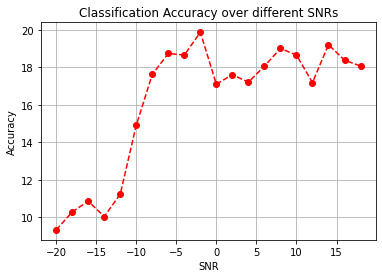

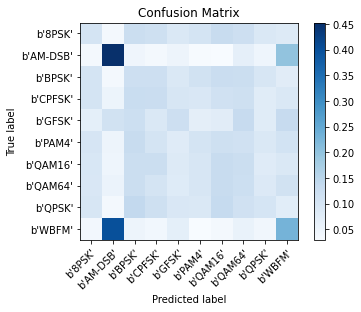

In [ ]:
print(print_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_valid[:,0]), LB().fit_transform(y_pred_valid), mods)

In [ ]:
print("Prediction test:", y_pred_test)
print("true test", y_test[:,0])
acc = accuracy_score(y_test[:,0], y_pred_test)
print("Accuracy test", acc)

Prediction test: [b'GFSK' b'PAM4' b'CPFSK' ... b'QAM64' b'PAM4' b'QAM64']
true test [b'QPSK' b'AM-DSB' b'8PSK' ... b'CPFSK' b'PAM4' b'CPFSK']
Accuracy test 0.16265


            -20   -18    -16    -14    -12  ...     10     12     14     16     18
accuracy  10.25  9.67  10.19  10.71  11.91  ...  18.36  18.65  18.72  17.69  18.28

[1 rows x 20 columns]


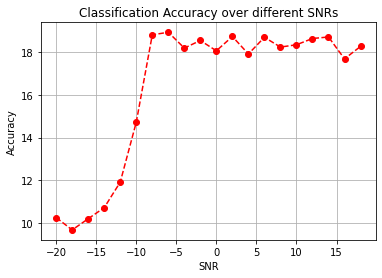

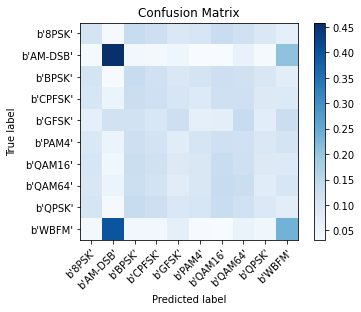

In [ ]:
print(print_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_test[:,0]), LB().fit_transform(y_pred_test), mods)

###Decision Tree



In [ ]:
dr = tree.DecisionTreeClassifier()
dr = dr.fit(x_train2, y_train[:,0])
y_pred_valid = dr.predict(x_valid2)
y_pred_test = dr.predict(x_test2)

####Evaluation

In [ ]:
print("Prediction validation:", y_pred_valid)
print("true validation", y_valid[:,0])
acc = accuracy_score(y_valid[:,0], y_pred_valid)
print("Accuracy validation", acc)

Prediction validation: [b'WBFM' b'BPSK' b'QAM16' ... b'WBFM' b'GFSK' b'PAM4']
true validation [b'WBFM' b'BPSK' b'PAM4' ... b'WBFM' b'GFSK' b'PAM4']
Accuracy validation 0.30976190476190474


            -20    -18    -16    -14    -12  ...     10     12     14     16     18
accuracy  10.74  10.09  10.46  10.27  10.38  ...  54.33  55.63  56.94  55.91  58.08

[1 rows x 20 columns]


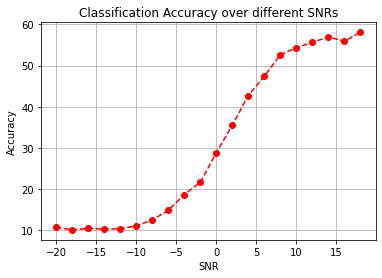

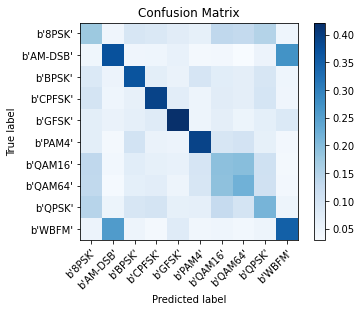

In [ ]:
print(print_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_valid[:,0]), LB().fit_transform(y_pred_valid), mods)

In [ ]:
print("Prediction test:", y_pred_test)
print("true test", y_test[:,0])
acc = accuracy_score(y_test[:,0], y_pred_test)
print("Accuracy test", acc)

Prediction test: [b'AM-DSB' b'QPSK' b'QPSK' ... b'QPSK' b'WBFM' b'CPFSK']
true test [b'QPSK' b'AM-DSB' b'8PSK' ... b'CPFSK' b'PAM4' b'CPFSK']
Accuracy test 0.30941111111111114


            -20    -18    -16    -14   -12  ...     10     12     14     16     18
accuracy  10.56  10.24  10.03  10.06  11.2  ...  55.02  55.98  56.49  56.36  57.26

[1 rows x 20 columns]


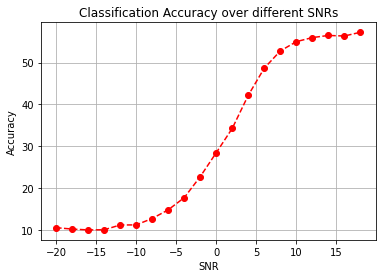

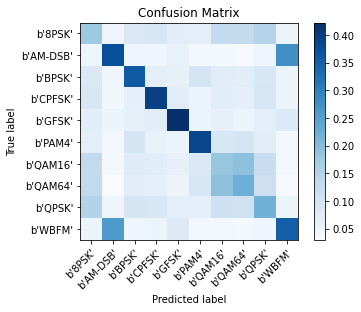

In [ ]:
print(print_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_test[:,0]), LB().fit_transform(y_pred_test), mods)

###Random Forest 



In [11]:
rfc=RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rfc.fit(x_train2,y_train[:,0])
y_pred_valid =rfc.predict(x_valid2)
y_pred_test=rfc.predict(x_test2)

####Evaluation

In [12]:
print("Prediction validation:", y_pred_valid)
print("true validation", y_valid[:,0])
acc = accuracy_score(y_valid[:,0], y_pred_valid)
print("Accuracy validation", acc)

Prediction validation: [b'BPSK' b'BPSK' b'BPSK' ... b'QPSK' b'BPSK' b'8PSK']
true validation [b'BPSK' b'QPSK' b'QAM64' ... b'QAM64' b'GFSK' b'CPFSK']
Accuracy validation 0.36788095238095236


           -20    -18    -16    -14    -12  ...     10     12     14     16     18
accuracy  8.96  10.91  10.05  10.11  11.16  ...  55.83  56.74  56.05  55.84  55.89

[1 rows x 20 columns]


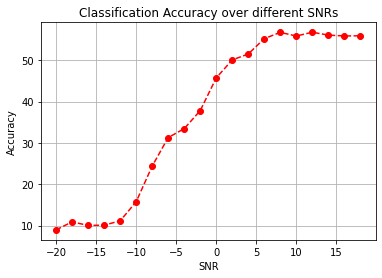

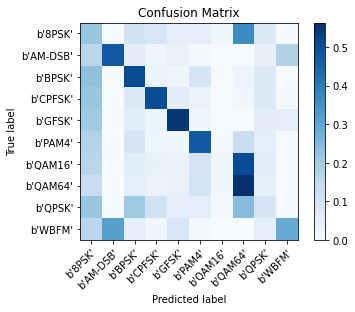

In [13]:
print(print_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_valid[:,0]), LB().fit_transform(y_pred_valid), mods)

In [14]:
print("Prediction test:", y_pred_test)
print("true test", y_test[:,0])
acc = accuracy_score(y_test[:,0], y_pred_test)
print("Accuracy test", acc)

Prediction test: [b'8PSK' b'PAM4' b'GFSK' ... b'AM-DSB' b'BPSK' b'8PSK']
true test [b'PAM4' b'CPFSK' b'BPSK' ... b'WBFM' b'PAM4' b'AM-DSB']
Accuracy test 0.3705611111111111


           -20   -18   -16    -14    -12  ...     10    12     14     16     18
accuracy  9.75  9.83  9.99  10.78  11.79  ...  55.63  56.5  56.38  56.71  56.35

[1 rows x 20 columns]


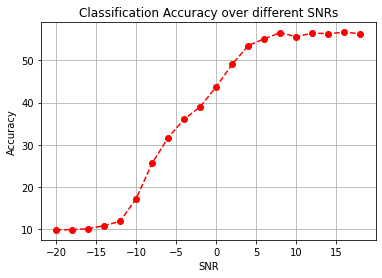

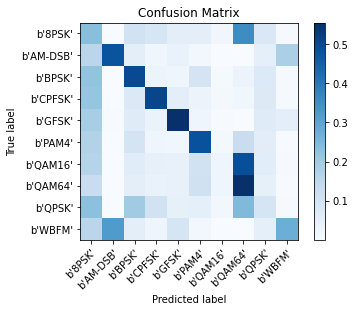

In [15]:
print(print_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_test[:,0]), LB().fit_transform(y_pred_test), mods)

###Fully Connected Dense Layer



In [ ]:
import random
n_examples = raw_feature.shape[0]
n_train = n_examples * 0.7
train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = raw_feature[train_idx]
X_test =  raw_feature[test_idx]
Y_train = LB().fit_transform(lbl[train_idx][:,0])
Y_test = LB().fit_transform(lbl[test_idx][:,0])

In [ ]:
print(X_train.shape,X_test.shape, Y_train.shape, Y_test.shape)

(840000, 2, 128) (360000, 2, 128) (840000, 10) (360000, 10)


In [ ]:
model = keras.Sequential()
model.add(layers.Dense(256, activation= "relu", name= "dense1",kernel_regularizer='l2', input_shape= (2, 128)))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation ='softmax')) #10 classes
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 2, 256)            33024     
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 38,154
Trainable params: 38,154
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 200
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
history = model.fit(
    X_train,
    Y_train,
    batch_size = 400,
    validation_split = 0.05,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/200
1995/1995 [==============================] - 5s 2ms/step - loss: 2.2238 - accuracy: 0.2183 - val_loss: 1.8859 - val_accuracy: 0.2975
Epoch 2/200
1995/1995 [==============================] - 5s 2ms/step - loss: 1.8702 - accuracy: 0.3030 - val_loss: 1.8335 - val_accuracy: 0.3157
Epoch 3/200
1995/1995 [==============================] - 5s 2ms/step - loss: 1.8269 - accuracy: 0.3184 - val_loss: 1.8075 - val_accuracy: 0.3251
Epoch 4/200
1995/1995 [==============================] - 5s 2ms/step - loss: 1.8049 - accuracy: 0.3239 - val_loss: 1.7923 - val_accuracy: 0.3266
Epoch 5/200
1995/1995 [==============================] - 5s 2ms/step - loss: 1.7897 - accuracy: 0.3255 - val_loss: 1.7880 - val_accuracy: 0.3260
Epoch 6/200
1995/1995 [==============================] - 5s 2ms/step - loss: 1.7839 - accuracy: 0.3269 - val_loss: 1.7735 - val_accuracy: 0.3306
Epoch 7/200
1995/1995 [==============================] - 5s 2ms/step - loss: 1.7744 - accuracy: 0.3293 - val_loss: 1.7680 - val_ac

####Evaluation

In [ ]:
results = model.evaluate(X_test, Y_test, batch_size=400)
y_pred_test = model.predict(X_test)
print("test loss, test acc:", results)

900/900 [==============================] - 2s 2ms/step - loss: 1.7242 - accuracy: 0.3340
test loss, test acc: [1.7242251634597778, 0.33400556445121765]


           -20    -18    -16    -14    -12  ...     10     12     14     16     18
accuracy  10.4  11.01  11.64  12.33  15.36  ...  41.25  41.27  42.21  41.23  41.01

[1 rows x 20 columns]


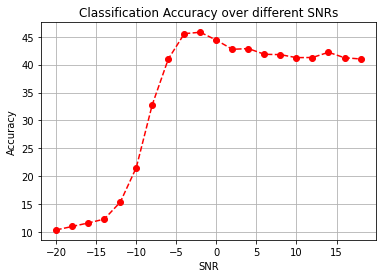

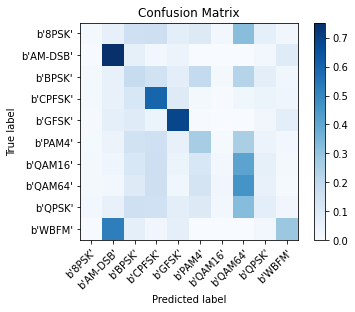

In [ ]:
snr_train = lbl[train_idx][:,1].astype(int)
snr_test = lbl[test_idx][:,1].astype(int)
print(print_results(y_pred_test,  Y_test, snr_test))
plot_results(y_pred_test,  Y_test, snr_test)
plot_confusion_matrix(Y_test, y_pred_test, mods)

###CNN Model

In [ ]:
from tensorflow.keras import layers
def cnn_model():
  #model = keras.Sequential()
  input_img = layers.Input(shape=(2, 128, 1), name="image")
  x = layers.Conv2D(64,(1,3), activation="relu", name="Conv1")(input_img)
  x = layers.Conv2D(16,(2,3),  activation="relu", name="Conv2")(x)
  x = layers.Flatten(name = 'flattened_img')(x)
  x = layers.Dense(128, activation="relu", name="dense1")(x)
  x = layers.Dense(10, activation="softmax", name="dense2")(x) #10 classes
  model = keras.models.Model(inputs=[input_img], outputs=x, name="cnn_model")
  return model

In [ ]:
model_cnn = cnn_model()
model_cnn.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 2, 128, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 2, 126, 64)        256       
_________________________________________________________________
Conv2 (Conv2D)               (None, 1, 124, 16)        6160      
_________________________________________________________________
flattened_img (Flatten)      (None, 1984)              0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               254080    
_________________________________________________________________
dense2 (Dense)               (None, 10)                1290      
Total params: 261,786
Trainable params: 261,786
Non-trainable params: 0
___________________________________________________

In [ ]:
model_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])
epochs = 200
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
history = model_cnn.fit(
    X_train,
    Y_train,
    batch_size = 400,
    validation_split = 0.05,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/200
1995/1995 [==============================] - 10s 5ms/step - loss: 1.6312 - accuracy: 0.3498 - val_loss: 1.1963 - val_accuracy: 0.5018
Epoch 2/200
1995/1995 [==============================] - 10s 5ms/step - loss: 1.1914 - accuracy: 0.4998 - val_loss: 1.1345 - val_accuracy: 0.5235
Epoch 3/200
1995/1995 [==============================] - 9s 5ms/step - loss: 1.1382 - accuracy: 0.5204 - val_loss: 1.1162 - val_accuracy: 0.5319
Epoch 4/200
1995/1995 [==============================] - 10s 5ms/step - loss: 1.1019 - accuracy: 0.5371 - val_loss: 1.0841 - val_accuracy: 0.5450
Epoch 5/200
1995/1995 [==============================] - 10s 5ms/step - loss: 1.0775 - accuracy: 0.5487 - val_loss: 1.0679 - val_accuracy: 0.5500
Epoch 6/200
1995/1995 [==============================] - 10s 5ms/step - loss: 1.0619 - accuracy: 0.5543 - val_loss: 1.0608 - val_accuracy: 0.5550
Epoch 7/200
1995/1995 [==============================] - 10s 5ms/step - loss: 1.0487 - accuracy: 0.5593 - val_loss: 1.0551 - 

####Evaluation

In [ ]:
results = model_cnn.evaluate(X_test, Y_test, batch_size=400)
y_pred_test = model_cnn.predict(X_test)
print("test loss, test acc:", results)

900/900 [==============================] - 3s 3ms/step - loss: 1.0529 - accuracy: 0.5590
test loss, test acc: [1.0528881549835205, 0.5590083599090576]


            -20    -18    -16    -14    -12  ...     10     12     14     16     18
accuracy  10.67  10.92  11.79  14.59  19.75  ...  81.69  82.24  82.13  81.79  81.99

[1 rows x 20 columns]


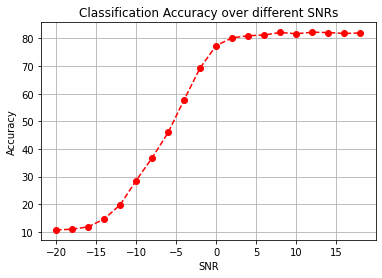

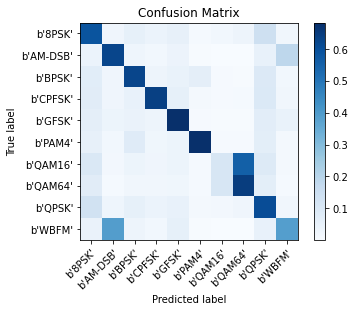

In [ ]:
snr_train = lbl[train_idx][:,1].astype(int)
snr_test = lbl[test_idx][:,1].astype(int)
print(print_results(y_pred_test,  Y_test, snr_test))
plot_results(y_pred_test,  Y_test, snr_test)
plot_confusion_matrix(Y_test, y_pred_test, mods)

# **First derivative in time**

##Feature Spaces

In [16]:
print(X.shape)
derivative_feature = normalize(np.gradient(X[:,0], axis = 1)), normalize(np.gradient(X[:,1], axis = 1))
derivative_feature = np.stack(derivative_feature, axis = 1)
print(derivative_feature)
print(derivative_feature.shape)
lbl = np.array(lbl)
in_shape = derivative_feature[0].shape
out_shape = tuple([1]) + in_shape
print(in_shape, out_shape)

(1200000, 2, 128)
[[[-0.06029993 -0.12386337 -0.01638079 ... -0.0186449   0.06209905
    0.09457203]
  [ 0.16911437  0.06956524 -0.03776356 ... -0.23020586 -0.01270726
   -0.0005663 ]]

 [[-0.13455155 -0.02764083  0.00650999 ... -0.0411226   0.04050773
   -0.05447972]
  [-0.34514645 -0.07355688  0.1361285  ... -0.02114303  0.03702613
    0.12621552]]

 [[-0.18550996 -0.00250622 -0.02935102 ...  0.06251812  0.2549248
    0.3008204 ]
  [-0.0445585   0.00260127  0.01163624 ... -0.06970791  0.01158406
    0.06449288]]

 ...

 [[-0.16397211 -0.15072271  0.05715781 ...  0.08676518 -0.01242725
    0.01578163]
  [-0.04016563 -0.06004853  0.07957528 ... -0.00850576  0.09017439
    0.11593006]]

 [[-0.11283428  0.02968843  0.05834858 ...  0.00151971 -0.01446231
   -0.05903269]
  [ 0.01565286 -0.03616421 -0.0380171  ...  0.02515107 -0.08338179
   -0.02031115]]

 [[-0.00847177  0.05038936  0.05964413 ...  0.05492792 -0.01224817
   -0.05917422]
  [-0.1121925  -0.01707977 -0.00930058 ...  0.06785503

**Helped_Link:** [Feature_Spaces](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html?fbclid=IwAR0VVCxswWf71tGfxfNENX7sX_DUS3hIIHrqBfuq2loHN22st8THrzfeHVM)

##Spliting DataSet

In [17]:
x_train,x_test,y_train,y_test = train_test_split(derivative_feature, lbl, test_size=0.3)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(840000, 2, 128) (840000, 2) (360000, 2, 128) (360000, 2)


In [18]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train , y_train, test_size=0.05)
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(798000, 2, 128) (798000, 2) (42000, 2, 128) (42000, 2)


In [19]:
nsamples, nx, ny = x_train.shape
x_train2 = x_train.reshape((nsamples, nx*ny))
nsamples, nx, ny = x_test.shape
x_test2 = x_test.reshape((nsamples, nx*ny))
nsamples, nx, ny = x_valid.shape
x_valid2 = x_valid.reshape((nsamples, nx*ny))

##Classifiers



###Logistic Regression

In [ ]:
lr = LogisticRegression()
lr = lr.fit(x_train2, y_train[:,0])
y_pred_valid = lr.predict(x_valid2)
y_pred_test = lr.predict(x_test2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


####Evaluation

In [ ]:
print("Prediction validation:", y_pred_valid)
print("true validation", y_valid[:,0])
acc = accuracy_score(y_valid[:,0], y_pred_valid)
print("Accuracy validation", acc)

Prediction validation: [b'WBFM' b'BPSK' b'QAM64' ... b'8PSK' b'8PSK' b'CPFSK']
true validation [b'8PSK' b'PAM4' b'CPFSK' ... b'PAM4' b'8PSK' b'AM-DSB']
Accuracy validation 0.11664285714285715


            -20   -18    -16    -14   -12  ...     10     12     14     16     18
accuracy  10.02  9.18  10.77  10.76  9.56  ...  13.42  13.49  13.28  14.09  12.38

[1 rows x 20 columns]


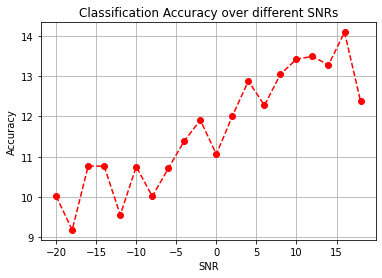

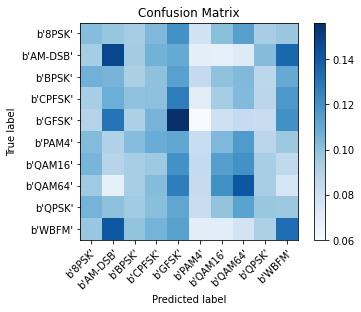

In [ ]:
print(print_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_valid[:,0]), LB().fit_transform(y_pred_valid), mods)

In [ ]:
print("Prediction test:", y_pred_test)
print("true test", y_test[:,0])
acc = accuracy_score(y_test[:,0], y_pred_test)
print("Accuracy test", acc)

Prediction test: [b'BPSK' b'BPSK' b'CPFSK' ... b'PAM4' b'GFSK' b'8PSK']
true test [b'AM-DSB' b'WBFM' b'BPSK' ... b'QPSK' b'PAM4' b'PAM4']
Accuracy test 0.115925


           -20    -18   -16    -14    -12  ...     10     12    14     16     18
accuracy  9.78  10.08  9.98  10.27  10.01  ...  13.35  13.63  13.5  14.12  13.99

[1 rows x 20 columns]


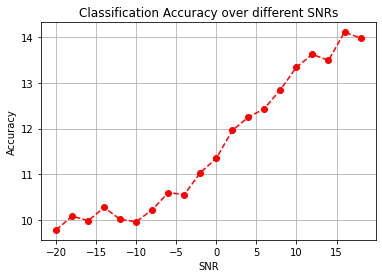

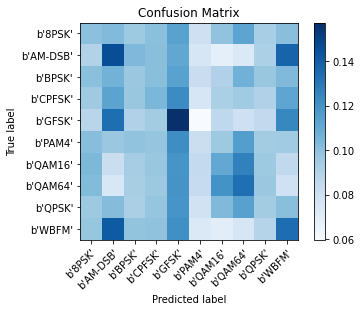

In [ ]:
print(print_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_test[:,0]), LB().fit_transform(y_pred_test), mods)

###Decision Tree



In [ ]:
dr = tree.DecisionTreeClassifier()
dr = dr.fit(x_train2, y_train[:,0])
y_pred_valid = dr.predict(x_valid2)
y_pred_test = dr.predict(x_test2)

In [ ]:
print("Prediction validation:", y_pred_valid)
print("true validation", y_valid[:,0])
acc = accuracy_score(y_valid[:,0], y_pred_valid)
print("Accuracy validation", acc)

Prediction validation: [b'GFSK' b'PAM4' b'WBFM' ... b'PAM4' b'WBFM' b'8PSK']
true validation [b'8PSK' b'PAM4' b'CPFSK' ... b'PAM4' b'8PSK' b'AM-DSB']
Accuracy validation 0.17509523809523808


####Evaluation

            -20   -18    -16   -14    -12  ...     10    12     14     16     18
accuracy  11.07  9.61  10.96  9.54  10.91  ...  26.84  29.4  32.37  34.21  35.94

[1 rows x 20 columns]


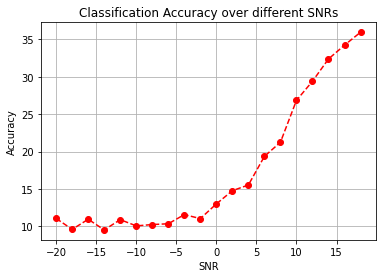

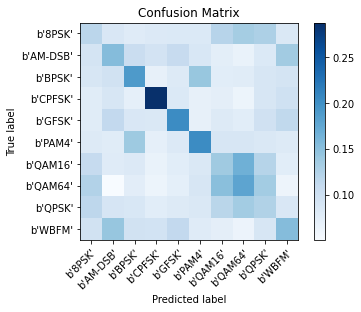

In [ ]:
print(print_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_valid[:,0]), LB().fit_transform(y_pred_valid), mods)

In [ ]:
print("Prediction test:", y_pred_test)
print("true test", y_test[:,0])
acc = accuracy_score(y_test[:,0], y_pred_test)
print("Accuracy test", acc)

Prediction test: [b'QAM64' b'AM-DSB' b'PAM4' ... b'WBFM' b'WBFM' b'AM-DSB']
true test [b'AM-DSB' b'WBFM' b'BPSK' ... b'QPSK' b'PAM4' b'PAM4']
Accuracy test 0.17413055555555557


           -20   -18   -16   -14   -12  ...     10     12     14    16     18
accuracy  10.1  9.75  9.94  9.87  9.99  ...  26.57  30.69  33.21  35.3  35.81

[1 rows x 20 columns]


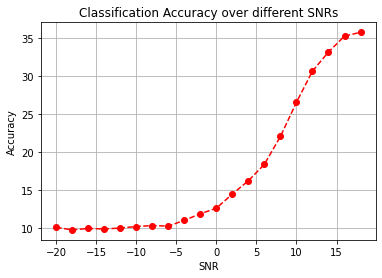

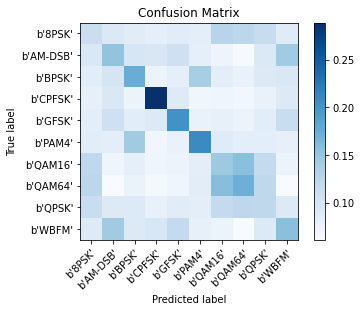

In [ ]:
print(print_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_test[:,0]), LB().fit_transform(y_pred_test), mods)

###Random Forest 



In [23]:
rfc=RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rfc.fit(x_train2,y_train[:,0])
y_pred_valid =rfc.predict(x_valid2)
y_pred_test=rfc.predict(x_test2)

####Evaluation

In [24]:
print("Prediction validation:", y_pred_valid)
print("true validation", y_valid[:,0])
acc = accuracy_score(y_valid[:,0], y_pred_valid)
print("Accuracy validation", acc)

Prediction validation: [b'AM-DSB' b'QAM64' b'QAM64' ... b'QAM64' b'QAM64' b'AM-DSB']
true validation [b'PAM4' b'QAM64' b'QPSK' ... b'QPSK' b'QAM64' b'WBFM']
Accuracy validation 0.2654761904761905


           -20    -18    -16   -14   -12  ...    10     12     14     16     18
accuracy  9.09  11.22  10.06  9.39  9.48  ...  46.1  48.08  45.94  44.25  47.28

[1 rows x 20 columns]


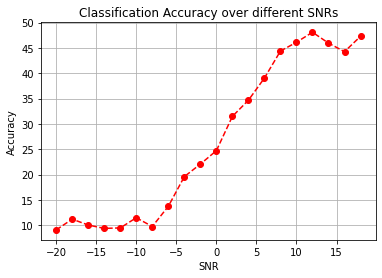

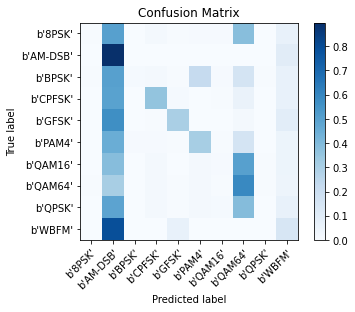

In [25]:
print(print_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_valid[:,0]), LB().fit_transform(y_pred_valid), mods)

In [26]:
print("Prediction test:", y_pred_test)
print("true test", y_test[:,0])
acc = accuracy_score(y_test[:,0], y_pred_test)
print("Accuracy test", acc)

Prediction test: [b'PAM4' b'PAM4' b'WBFM' ... b'AM-DSB' b'AM-DSB' b'CPFSK']
true test [b'PAM4' b'BPSK' b'WBFM' ... b'PAM4' b'BPSK' b'GFSK']
Accuracy test 0.26219166666666666


            -20   -18    -16   -14   -12  ...     10     12     14     16     18
accuracy  10.07  9.89  10.26  9.97  9.83  ...  45.47  46.12  45.87  46.46  45.19

[1 rows x 20 columns]


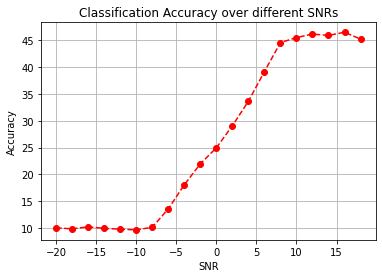

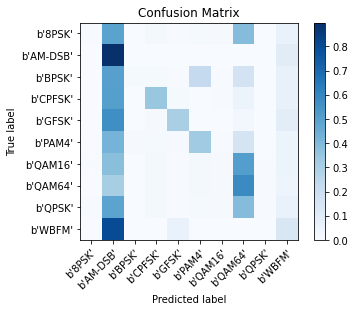

In [27]:
print(print_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_test[:,0]), LB().fit_transform(y_pred_test), mods)

###Fully Connected Dense Layer



In [ ]:
import random
n_examples = derivative_feature.shape[0]
n_train = n_examples * 0.7
train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = derivative_feature[train_idx]
X_test =  derivative_feature[test_idx]
Y_train = LB().fit_transform(lbl[train_idx][:,0])
Y_test = LB().fit_transform(lbl[test_idx][:,0])

In [ ]:
print(X_train.shape,X_test.shape, Y_train.shape, Y_test.shape)

(840000, 2, 128) (360000, 2, 128) (840000, 10) (360000, 10)


In [ ]:
model = keras.Sequential()
model.add(layers.Dense(256, activation= "relu", name= "dense1",kernel_regularizer='l2', input_shape= (2, 128)))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation ='softmax')) #10 classes
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 2, 256)            33024     
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                5130      
Total params: 38,154
Trainable params: 38,154
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 200
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
history = model.fit(
    X_train,
    Y_train,
    batch_size = 400,
    validation_split = 0.05,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/200
1995/1995 [==============================] - 7s 3ms/step - loss: 2.3796 - accuracy: 0.1751 - val_loss: 2.1010 - val_accuracy: 0.2348
Epoch 2/200
1995/1995 [==============================] - 5s 3ms/step - loss: 2.0860 - accuracy: 0.2429 - val_loss: 2.0575 - val_accuracy: 0.2532
Epoch 3/200
1995/1995 [==============================] - 5s 3ms/step - loss: 2.0478 - accuracy: 0.2573 - val_loss: 2.0349 - val_accuracy: 0.2569
Epoch 4/200
1995/1995 [==============================] - 5s 2ms/step - loss: 2.0272 - accuracy: 0.2641 - val_loss: 2.0180 - val_accuracy: 0.2667
Epoch 5/200
1995/1995 [==============================] - 5s 2ms/step - loss: 2.0162 - accuracy: 0.2666 - val_loss: 2.0109 - val_accuracy: 0.2687
Epoch 6/200
1995/1995 [==============================] - 5s 2ms/step - loss: 2.0072 - accuracy: 0.2694 - val_loss: 2.0051 - val_accuracy: 0.2715
Epoch 7/200
1995/1995 [==============================] - 5s 2ms/step - loss: 2.0012 - accuracy: 0.2722 - val_loss: 1.9967 - val_ac

####Evaluation

In [ ]:
results = model.evaluate(X_test, Y_test, batch_size=400)
y_pred_test = model.predict(X_test)
print("test loss, test acc:", results)

900/900 [==============================] - 2s 2ms/step - loss: 1.9174 - accuracy: 0.2933
test loss, test acc: [1.917381763458252, 0.29330000281333923]


           -20   -18   -16    -14    -12  ...     10     12     14    16     18
accuracy  9.92  9.96  9.85  10.03  10.58  ...  42.75  42.16  41.21  40.2  39.37

[1 rows x 20 columns]


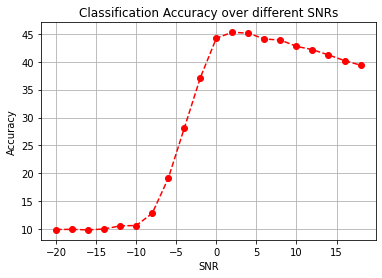

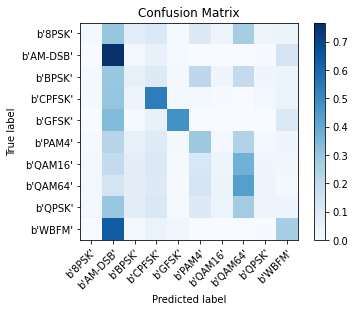

In [ ]:
snr_train = lbl[train_idx][:,1].astype(int)
snr_test = lbl[test_idx][:,1].astype(int)
print(print_results(y_pred_test,  Y_test, snr_test))
plot_results(y_pred_test,  Y_test, snr_test)
plot_confusion_matrix(Y_test, y_pred_test, mods)

###CNN Model

In [ ]:
from tensorflow.keras import layers
def cnn_model():
  #model = keras.Sequential()
  input_img = layers.Input(shape=(2, 128, 1), name="image")
  x = layers.Conv2D(64,(1,3), activation="relu", name="Conv1")(input_img)
  x = layers.Conv2D(16,(2,3),  activation="relu", name="Conv2")(x)
  x = layers.Flatten(name = 'flattened_img')(x)
  x = layers.Dense(128, activation="relu", name="dense1")(x)
  x = layers.Dense(10, activation="softmax", name="dense2")(x)
  model = keras.models.Model(inputs=[input_img], outputs=x, name="cnn_model")
  return model

In [ ]:
model_cnn = cnn_model()
model_cnn.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 2, 128, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 2, 126, 64)        256       
_________________________________________________________________
Conv2 (Conv2D)               (None, 1, 124, 16)        6160      
_________________________________________________________________
flattened_img (Flatten)      (None, 1984)              0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               254080    
_________________________________________________________________
dense2 (Dense)               (None, 10)                1290      
Total params: 261,786
Trainable params: 261,786
Non-trainable params: 0
___________________________________________________

In [ ]:
model_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])
epochs = 200
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
history = model_cnn.fit(
    X_train,
    Y_train,
    batch_size = 400,
    validation_split = 0.05,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/200
1995/1995 [==============================] - 16s 5ms/step - loss: 1.9380 - accuracy: 0.2596 - val_loss: 1.6319 - val_accuracy: 0.3564
Epoch 2/200
1995/1995 [==============================] - 10s 5ms/step - loss: 1.5967 - accuracy: 0.3763 - val_loss: 1.5651 - val_accuracy: 0.3886
Epoch 3/200
1995/1995 [==============================] - 10s 5ms/step - loss: 1.5328 - accuracy: 0.4020 - val_loss: 1.5295 - val_accuracy: 0.3964
Epoch 4/200
1995/1995 [==============================] - 10s 5ms/step - loss: 1.5033 - accuracy: 0.4121 - val_loss: 1.5111 - val_accuracy: 0.4088
Epoch 5/200
1995/1995 [==============================] - 10s 5ms/step - loss: 1.4797 - accuracy: 0.4213 - val_loss: 1.5159 - val_accuracy: 0.4028
Epoch 6/200
1995/1995 [==============================] - 10s 5ms/step - loss: 1.4610 - accuracy: 0.4292 - val_loss: 1.4950 - val_accuracy: 0.4090
Epoch 7/200
1995/1995 [==============================] - 10s 5ms/step - loss: 1.4470 - accuracy: 0.4342 - val_loss: 1.4891 -

####Evaluation

In [ ]:
results = model_cnn.evaluate(X_test, Y_test, batch_size=400)
y_pred_test = model_cnn.predict(X_test)
print("test loss, test acc:", results)

900/900 [==============================] - 3s 3ms/step - loss: 1.4725 - accuracy: 0.4246
test loss, test acc: [1.472480058670044, 0.4246055483818054]


            -20   -18    -16    -14    -12  ...     10     12     14     16     18
accuracy  10.24  9.98  10.15  10.02  11.94  ...  70.01  68.92  68.57  67.68  66.83

[1 rows x 20 columns]


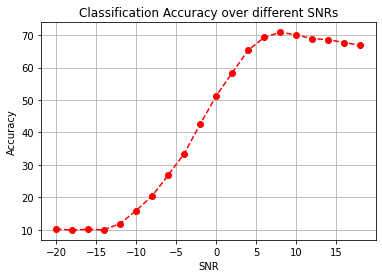

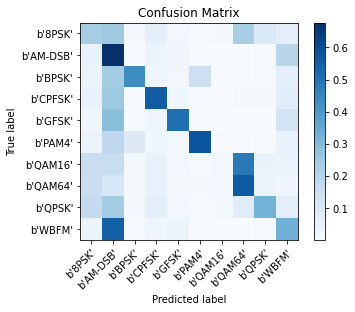

In [ ]:
snr_train = lbl[train_idx][:,1].astype(int)
snr_test = lbl[test_idx][:,1].astype(int)
print(print_results(y_pred_test,  Y_test, snr_test))
plot_results(y_pred_test,  Y_test, snr_test)
plot_confusion_matrix(Y_test, y_pred_test, mods)

# **Integral in time**

##Feature Spaces

In [28]:
print(X.shape)
integral_feature = normalize(np.cumsum(X[:,0], axis = 1)), normalize(np.cumsum(X[:,1], axis = 1))
integral_feature = np.stack(integral_feature, axis = 1)
print(integral_feature)
print(integral_feature.shape)
lbl = np.array(lbl)
in_shape = integral_feature[0].shape
out_shape = tuple([1]) + in_shape
print(in_shape, out_shape)

(1200000, 2, 128)
[[[ 0.01147853  0.01906481  0.01455302 ...  0.15236448  0.15129553
    0.15633103]
  [-0.00155472  0.02141102  0.04002929 ... -0.02201433 -0.0440998
   -0.06626738]]

 [[-0.00615713 -0.02160878 -0.03158464 ... -0.14844999 -0.1523091
   -0.15993154]
  [ 0.01931132 -0.00154867  0.0006402  ...  0.13048658  0.12792528
    0.14005409]]

 [[ 0.00813042 -0.03108993 -0.02423892 ... -0.08297462 -0.05955883
    0.04064029]
  [-0.00561907 -0.02465524 -0.02870776 ... -0.05373027 -0.05503425
   -0.03691867]]

 ...

 [[ 0.00119853  0.00236474  0.00350384 ...  0.15040502  0.1516301
    0.15285832]
  [-0.00118417 -0.00237157 -0.0035654  ... -0.14976272 -0.1509522
   -0.15213236]]

 [[ 0.00118075  0.0023467   0.00353525 ...  0.15025946  0.15145004
    0.15263286]
  [-0.00119586 -0.00239046 -0.0035921  ... -0.14965747 -0.15083422
   -0.15201257]]

 [[ 0.0011848   0.00236868  0.00356431 ...  0.14995949  0.15116388
    0.15236188]
  [-0.00118539 -0.0023808  -0.00356924 ... -0.14983301 -0

**Helped_Link:** [Feature_Spaces](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html?fbclid=IwAR0VVCxswWf71tGfxfNENX7sX_DUS3hIIHrqBfuq2loHN22st8THrzfeHVM)

##Spliting DataSet

In [29]:
x_train,x_test,y_train,y_test = train_test_split(integral_feature, lbl, test_size=0.3)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(840000, 2, 128) (840000, 2) (360000, 2, 128) (360000, 2)


In [30]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train , y_train, test_size=0.05)
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(798000, 2, 128) (798000, 2) (42000, 2, 128) (42000, 2)


In [31]:
nsamples, nx, ny = x_train.shape
x_train2 = x_train.reshape((nsamples, nx*ny))
nsamples, nx, ny = x_test.shape
x_test2 = x_test.reshape((nsamples, nx*ny))
nsamples, nx, ny = x_valid.shape
x_valid2 = x_valid.reshape((nsamples, nx*ny))

##Classifiers



###Logistic Regression

In [ ]:
lr = LogisticRegression()
lr = lr.fit(x_train2, y_train[:,0])
y_pred_valid = lr.predict(x_valid2)
y_pred_test = lr.predict(x_test2)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


####Evaluation

In [ ]:
print("Prediction validation:", y_pred_valid)
print("true validation", y_valid[:,0])
acc = accuracy_score(y_valid[:,0], y_pred_valid)
print("Accuracy validation", acc)

Prediction validation: [b'PAM4' b'AM-DSB' b'WBFM' ... b'QPSK' b'AM-DSB' b'CPFSK']
true validation [b'CPFSK' b'WBFM' b'QPSK' ... b'QAM16' b'AM-DSB' b'QAM16']
Accuracy validation 0.15004761904761904


            -20    -18    -16    -14    -12  ...     10     12     14     16     18
accuracy  10.91  11.29  12.05  12.63  14.74  ...  15.64  16.51  16.83  15.83  14.48

[1 rows x 20 columns]


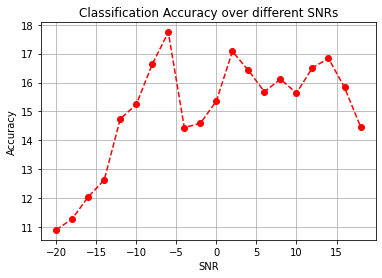

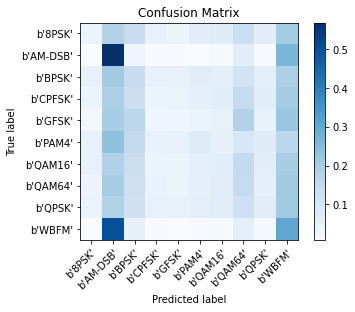

In [ ]:
print(print_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_valid[:,0]), LB().fit_transform(y_pred_valid), mods)

In [ ]:
print("Prediction test:", y_pred_test)
print("true test", y_test[:,0])
acc = accuracy_score(y_test[:,0], y_pred_test)
print("Accuracy test", acc)

Prediction test: [b'QAM16' b'QAM64' b'BPSK' ... b'QAM64' b'CPFSK' b'AM-DSB']
true test [b'QAM64' b'PAM4' b'8PSK' ... b'PAM4' b'QAM16' b'8PSK']
Accuracy test 0.14859166666666668


            -20    -18    -16    -14    -12  ...     10     12     14    16    18
accuracy  10.68  11.44  11.75  13.56  14.32  ...  16.21  15.67  15.87  15.7  15.3

[1 rows x 20 columns]


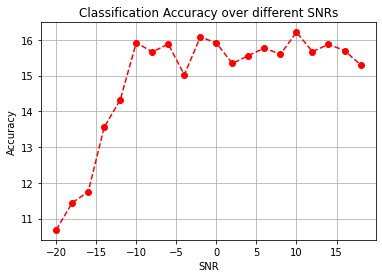

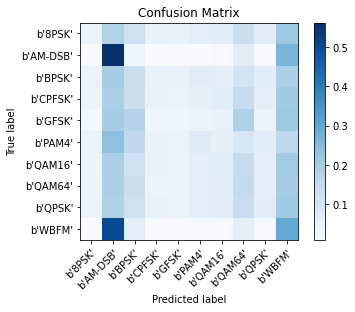

In [ ]:
print(print_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_test[:,0]), LB().fit_transform(y_pred_test), mods)

###Decision Tree



In [ ]:
dr = tree.DecisionTreeClassifier()
dr = dr.fit(x_train2, y_train[:,0])
y_pred_valid = dr.predict(x_valid2)
y_pred_test = dr.predict(x_test2)

####Evaluation

In [ ]:
print("Prediction validation:", y_pred_valid)
print("true validation", y_valid[:,0])
acc = accuracy_score(y_valid[:,0], y_pred_valid)
print("Accuracy validation", acc)

Prediction validation: [b'CPFSK' b'AM-DSB' b'QPSK' ... b'8PSK' b'AM-DSB' b'QPSK']
true validation [b'CPFSK' b'WBFM' b'QPSK' ... b'QAM16' b'AM-DSB' b'QAM16']
Accuracy validation 0.2595952380952381


            -20    -18   -16    -14   -12  ...    10     12     14    16     18
accuracy  10.21  10.96  9.77  11.17  10.9  ...  38.9  39.56  39.77  39.0  39.42

[1 rows x 20 columns]


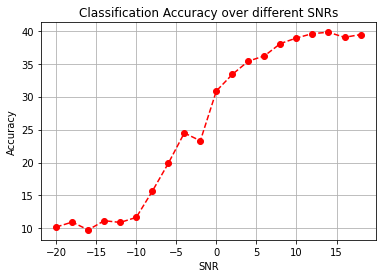

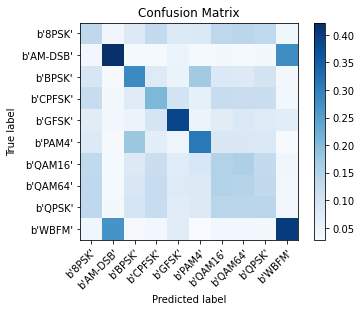

In [ ]:
print(print_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_valid[:,0]), LB().fit_transform(y_pred_valid), mods)

In [ ]:
print("Prediction test:", y_pred_test)
print("true test", y_test[:,0])
acc = accuracy_score(y_test[:,0], y_pred_test)
print("Accuracy test", acc)

Prediction test: [b'QAM16' b'BPSK' b'8PSK' ... b'8PSK' b'BPSK' b'GFSK']
true test [b'QAM64' b'PAM4' b'8PSK' ... b'PAM4' b'QAM16' b'8PSK']
Accuracy test 0.2584361111111111


           -20   -18    -16    -14    -12  ...     10     12     14     16     18
accuracy  9.97  9.79  10.47  10.97  11.73  ...  38.35  38.65  38.92  39.39  39.18

[1 rows x 20 columns]


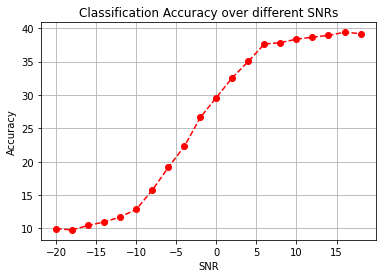

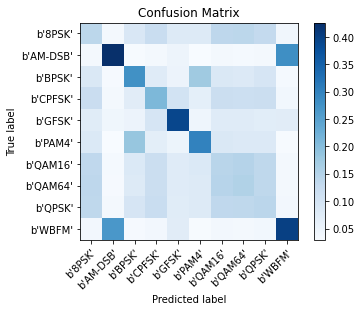

In [ ]:
print(print_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_test[:,0]), LB().fit_transform(y_pred_test), mods)

###Random Forest 



In [ ]:
rfc=RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rfc.fit(x_train2,y_train[:,0])
y_pred_valid =rfc.predict(x_valid2)
y_pred_test=rfc.predict(x_test2)

####Evaluation

In [ ]:
print("Prediction validation:", y_pred_valid)
print("true validation", y_valid[:,0])
acc = accuracy_score(y_valid[:,0], y_pred_valid)
print("Accuracy validation", acc)

Prediction validation: [b'GFSK' b'GFSK' b'8PSK' ... b'PAM4' b'GFSK' b'PAM4']
true validation [b'8PSK' b'CPFSK' b'8PSK' ... b'PAM4' b'GFSK' b'PAM4']
Accuracy validation 0.2888095238095238


            -20   -18    -16    -14    -12  ...     10     12    14     16     18
accuracy  10.82  9.76  11.34  10.38  13.95  ...  38.44  40.34  39.7  39.95  38.53

[1 rows x 20 columns]


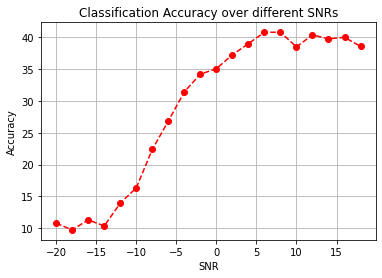

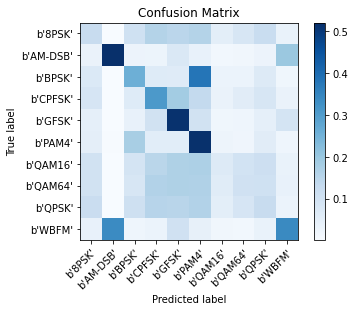

In [ ]:
print(print_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_valid[:,0]), LB().fit_transform(y_pred_valid), mods)

In [ ]:
print("Prediction test:", y_pred_test)
print("true test", y_test[:,0])
acc = accuracy_score(y_test[:,0], y_pred_test)
print("Accuracy test", acc)

Prediction test: [b'CPFSK' b'QPSK' b'CPFSK' ... b'CPFSK' b'GFSK' b'CPFSK']
true test [b'CPFSK' b'QAM16' b'CPFSK' ... b'QAM16' b'QAM64' b'QAM64']
Accuracy test 0.2909277777777778


            -20    -18    -16    -14    -12  ...     10     12     14     16     18
accuracy  10.13  10.66  10.52  11.51  13.63  ...  40.54  40.37  40.67  40.32  39.11

[1 rows x 20 columns]


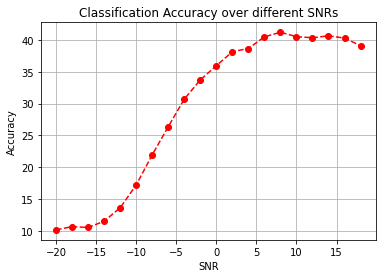

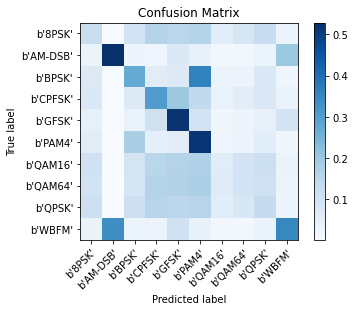

In [ ]:
print(print_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_test[:,0]), LB().fit_transform(y_pred_test), mods)

###Fully Connected Dense Layer



In [ ]:
import random
n_examples = integral_feature.shape[0]
n_train = n_examples * 0.7
#a = range(0,n_examples)
train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = integral_feature[train_idx]
X_test =  integral_feature[test_idx]
Y_train = LB().fit_transform(lbl[train_idx][:,0])
Y_test = LB().fit_transform(lbl[test_idx][:,0])

In [ ]:
print(X_train.shape,X_test.shape, Y_train.shape, Y_test.shape)

(840000, 2, 128) (360000, 2, 128) (840000, 10) (360000, 10)


In [ ]:
model = keras.Sequential()
model.add(layers.Dense(256, activation= "relu", name= "dense1",kernel_regularizer='l2', input_shape= (2, 128)))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation ='softmax')) #10 classes
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 2, 256)            33024     
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                5130      
Total params: 38,154
Trainable params: 38,154
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 200
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
history = model.fit(
    X_train,
    Y_train,
    batch_size = 400,
    validation_split = 0.05,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/200
1995/1995 [==============================] - 6s 3ms/step - loss: 2.3392 - accuracy: 0.1625 - val_loss: 2.1308 - val_accuracy: 0.1861
Epoch 2/200
1995/1995 [==============================] - 5s 2ms/step - loss: 2.1271 - accuracy: 0.1912 - val_loss: 2.1140 - val_accuracy: 0.1947
Epoch 3/200
1995/1995 [==============================] - 5s 2ms/step - loss: 2.1068 - accuracy: 0.2003 - val_loss: 2.0919 - val_accuracy: 0.2038
Epoch 4/200
1995/1995 [==============================] - 5s 2ms/step - loss: 2.0906 - accuracy: 0.2074 - val_loss: 2.0795 - val_accuracy: 0.2125
Epoch 5/200
1995/1995 [==============================] - 5s 2ms/step - loss: 2.0783 - accuracy: 0.2119 - val_loss: 2.0681 - val_accuracy: 0.2224
Epoch 6/200
1995/1995 [==============================] - 5s 2ms/step - loss: 2.0687 - accuracy: 0.2163 - val_loss: 2.0582 - val_accuracy: 0.2177
Epoch 7/200
1995/1995 [==============================] - 5s 2ms/step - loss: 2.0602 - accuracy: 0.2186 - val_loss: 2.0465 - val_ac

####Evaluation

In [ ]:
results = model.evaluate(X_test, Y_test, batch_size=400)
y_pred_test = model.predict(X_test)
print("test loss, test acc:", results)

900/900 [==============================] - 2s 2ms/step - loss: 1.9816 - accuracy: 0.2515
test loss, test acc: [1.981646180152893, 0.2514500021934509]


            -20    -18    -16    -14    -12  ...     10     12    14     16     18
accuracy  10.68  10.49  11.44  12.61  14.94  ...  31.43  30.66  32.3  31.49  31.36

[1 rows x 20 columns]


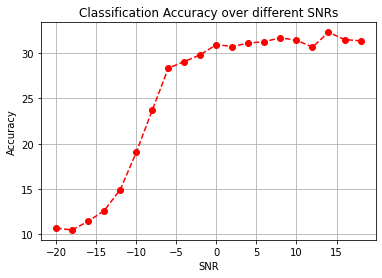

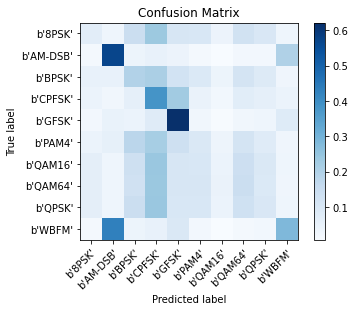

In [ ]:
snr_train = lbl[train_idx][:,1].astype(int)
snr_test = lbl[test_idx][:,1].astype(int)
print(print_results(y_pred_test,  Y_test, snr_test))
plot_results(y_pred_test,  Y_test, snr_test)
plot_confusion_matrix(Y_test, y_pred_test, mods)

###CNN Model

In [ ]:
from tensorflow.keras import layers
def cnn_model():
  #model = keras.Sequential()
  input_img = layers.Input(shape=(2, 128, 1), name="image")
  x = layers.Conv2D(64,(1,3), activation="relu", name="Conv1")(input_img)
  x = layers.Conv2D(16,(2,3),  activation="relu", name="Conv2")(x)
  x = layers.Flatten(name = 'flattened_img')(x)
  x = layers.Dense(128, activation="relu", name="dense1")(x)
  x = layers.Dense(10, activation="softmax", name="dense2")(x)
  model = keras.models.Model(inputs=[input_img], outputs=x, name="cnn_model")
  return model

In [ ]:
model_cnn = cnn_model()
model_cnn.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 2, 128, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 2, 126, 64)        256       
_________________________________________________________________
Conv2 (Conv2D)               (None, 1, 124, 16)        6160      
_________________________________________________________________
flattened_img (Flatten)      (None, 1984)              0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               254080    
_________________________________________________________________
dense2 (Dense)               (None, 10)                1290      
Total params: 261,786
Trainable params: 261,786
Non-trainable params: 0
___________________________________________________

In [ ]:
model_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])
epochs = 200
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
history = model_cnn.fit(
    X_train,
    Y_train,
    batch_size = 400,
    validation_split = 0.05,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/200
1995/1995 [==============================] - 13s 5ms/step - loss: 1.9962 - accuracy: 0.2306 - val_loss: 1.7614 - val_accuracy: 0.3016
Epoch 2/200
1995/1995 [==============================] - 10s 5ms/step - loss: 1.7366 - accuracy: 0.3048 - val_loss: 1.6788 - val_accuracy: 0.3243
Epoch 3/200
1995/1995 [==============================] - 9s 5ms/step - loss: 1.6622 - accuracy: 0.3260 - val_loss: 1.6275 - val_accuracy: 0.3371
Epoch 4/200
1995/1995 [==============================] - 10s 5ms/step - loss: 1.6156 - accuracy: 0.3390 - val_loss: 1.5792 - val_accuracy: 0.3520
Epoch 5/200
1995/1995 [==============================] - 10s 5ms/step - loss: 1.5676 - accuracy: 0.3546 - val_loss: 1.5514 - val_accuracy: 0.3643
Epoch 6/200
1995/1995 [==============================] - 10s 5ms/step - loss: 1.5216 - accuracy: 0.3754 - val_loss: 1.4921 - val_accuracy: 0.3803
Epoch 7/200
1995/1995 [==============================] - 10s 5ms/step - loss: 1.4755 - accuracy: 0.3997 - val_loss: 1.4514 - 

####Evaluation

In [ ]:
results = model_cnn.evaluate(X_test, Y_test, batch_size=400)
y_pred_test = model_cnn.predict(X_test)
print("test loss, test acc:", results)

900/900 [==============================] - 3s 3ms/step - loss: 1.1838 - accuracy: 0.5125
test loss, test acc: [1.1837892532348633, 0.5124972462654114]


            -20    -18    -16    -14    -12  ...     10     12     14     16     18
accuracy  10.31  10.99  11.68  13.35  16.77  ...  75.93  75.78  76.14  75.99  76.24

[1 rows x 20 columns]


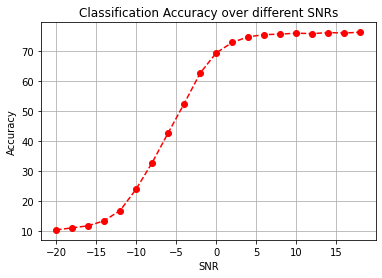

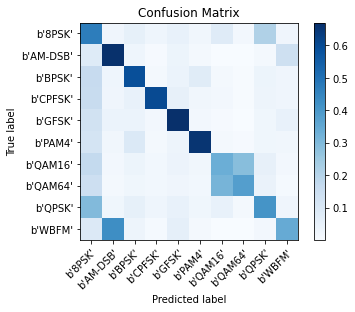

In [ ]:
snr_train = lbl[train_idx][:,1].astype(int)
snr_test = lbl[test_idx][:,1].astype(int)
print(print_results(y_pred_test,  Y_test, snr_test))
plot_results(y_pred_test,  Y_test, snr_test)
plot_confusion_matrix(Y_test, y_pred_test, mods)

# **Combinations of Raw and derivative**

##Feature Spaces

In [ ]:
del Xd
print(X.shape)
raw = normalize(X[:,0]), normalize(X[:,1])
derivative = normalize(np.gradient(X[:,0], axis = 1)), normalize(np.gradient(X[:,1], axis = 1))
print('Finish')
com_feature = raw
com_feature += derivative
del X
del raw
del derivative
com_feature = np.stack(com_feature, axis = 1)
print(com_feature)
print(com_feature.shape)
lbl = np.array(lbl)

(1200000, 2, 128)
Finish
[[[ 0.12533608  0.0828359  -0.049265   ... -0.0325529  -0.01167205
    0.05498357]
  [-0.00755202  0.11155538  0.0904377  ... -0.08977888 -0.10727949
   -0.10767834]
  [-0.06029993 -0.12386337 -0.01638079 ... -0.0186449   0.06209905
    0.09457203]
  [ 0.16911437  0.06956524 -0.03776356 ... -0.23020586 -0.01270726
   -0.0005663 ]]

 [[-0.06435594 -0.1615047  -0.10427034 ... -0.13816652 -0.04033643
   -0.07967182]
  [ 0.1242578  -0.13422264  0.01408419 ...  0.0225845  -0.01648061
    0.0780423 ]
  [-0.13455155 -0.02764083  0.00650999 ... -0.0411226   0.04050773
   -0.05447972]
  [-0.34514645 -0.07355688  0.1361285  ... -0.02114303  0.03702613
    0.12621552]]

 [[ 0.0245417  -0.11838678  0.0206798  ... -0.09036851  0.07068066
    0.30245152]
  [-0.01437539 -0.04870061 -0.01036766 ...  0.02849814 -0.003336
    0.04634549]
  [-0.18550996 -0.00250622 -0.02935102 ...  0.06251812  0.2549248
    0.3008204 ]
  [-0.0445585   0.00260127  0.01163624 ... -0.06970791  0.011

**Helped_Link:** [Feature_Spaces](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html?fbclid=IwAR0VVCxswWf71tGfxfNENX7sX_DUS3hIIHrqBfuq2loHN22st8THrzfeHVM)

##Spliting DataSet

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(com_feature, lbl, test_size=0.3)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(840000, 4, 128) (840000, 2) (360000, 4, 128) (360000, 2)


In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train , y_train, test_size=0.05)
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(798000, 4, 128) (798000, 2) (42000, 4, 128) (42000, 2)


In [ ]:
nsamples, nx, ny = x_train.shape
x_train2 = x_train.reshape((nsamples, nx*ny))
nsamples, nx, ny = x_test.shape
x_test2 = x_test.reshape((nsamples, nx*ny))
nsamples, nx, ny = x_valid.shape
x_valid2 = x_valid.reshape((nsamples, nx*ny))
del x_train
del x_valid
del x_test
del com_feature
del lbl

In [ ]:
import random
n_examples = com_feature.shape[0]
n_train = n_examples * 0.7
#a = range(0,n_examples)
train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = com_feature[train_idx]
X_test =  com_feature[test_idx]
Y_train = LB().fit_transform(lbl[train_idx][:,0])
Y_test = LB().fit_transform(lbl[test_idx][:,0])
snr_train = lbl[train_idx][:,1].astype(int)
snr_test = lbl[test_idx][:,1].astype(int)
del lbl
del com_feature

In [ ]:
print(X_train.shape,X_test.shape, Y_train.shape, Y_test.shape)

(840000, 4, 128) (360000, 4, 128) (840000, 10) (360000, 10)


##Classifiers



###Logistic Regression

In [ ]:
lr = LogisticRegression()
lr = lr.fit(x_train2, y_train[:,0])
y_pred_valid = lr.predict(x_valid2)
y_pred_test = lr.predict(x_test2)
del lr

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


####Evaluation

In [ ]:
print("Prediction validation:", y_pred_valid)
print("true validation", y_valid[:,0])
acc = accuracy_score(y_valid[:,0], y_pred_valid)
print("Accuracy validation", acc)

Prediction validation: [b'QAM16' b'AM-DSB' b'QAM64' ... b'GFSK' b'QAM16' b'WBFM']
true validation [b'8PSK' b'AM-DSB' b'CPFSK' ... b'8PSK' b'QPSK' b'CPFSK']
Accuracy validation 0.16457142857142856


            -20    -18  -16    -14    -12  ...     10     12     14     16     18
accuracy  10.55  10.43  9.7  10.06  10.08  ...  20.05  18.62  20.36  18.53  19.34

[1 rows x 20 columns]


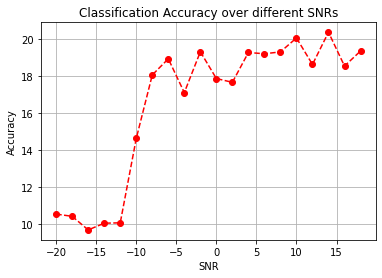

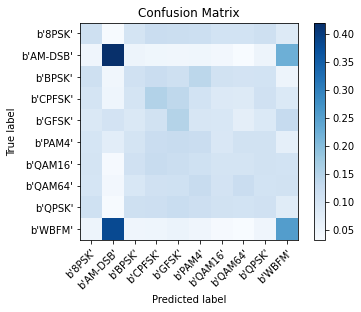

In [ ]:
print(print_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_valid[:,0]), LB().fit_transform(y_pred_valid), mods)

In [ ]:
print("Prediction test:", y_pred_test)
print("true test", y_test[:,0])
acc = accuracy_score(y_test[:,0], y_pred_test)
print("Accuracy test", acc)

Prediction test: [b'PAM4' b'CPFSK' b'8PSK' ... b'PAM4' b'PAM4' b'QAM16']
true test [b'QAM64' b'QAM16' b'CPFSK' ... b'BPSK' b'QAM16' b'CPFSK']
Accuracy test 0.1636138888888889


            -20    -18    -16    -14    -12  ...     10     12    14    16     18
accuracy  10.22  10.24  10.79  10.34  11.85  ...  18.73  19.43  19.8  19.2  19.18

[1 rows x 20 columns]


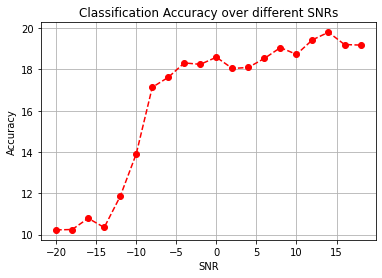

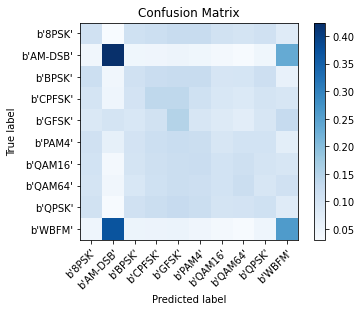

In [ ]:
print(print_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_test[:,0]), LB().fit_transform(y_pred_test), mods)

###Decision Tree



In [ ]:
dr = tree.DecisionTreeClassifier()
dr = dr.fit(x_train2, y_train[:,0])
y_pred_valid = dr.predict(x_valid2)
y_pred_test = dr.predict(x_test2)
del dr

####Evaluation

In [ ]:
print("Prediction validation:", y_pred_valid)
print("true validation", y_valid[:,0])
acc = accuracy_score(y_valid[:,0], y_pred_valid)
print("Accuracy validation", acc)

Prediction validation: [b'BPSK' b'QAM16' b'GFSK' ... b'8PSK' b'QPSK' b'CPFSK']
true validation [b'8PSK' b'AM-DSB' b'CPFSK' ... b'8PSK' b'QPSK' b'CPFSK']
Accuracy validation 0.2935952380952381


            -20    -18    -16    -14    -12  ...     10     12     14     16     18
accuracy  10.55  10.04  10.69  11.06  11.01  ...  53.33  52.11  57.41  56.43  56.74

[1 rows x 20 columns]


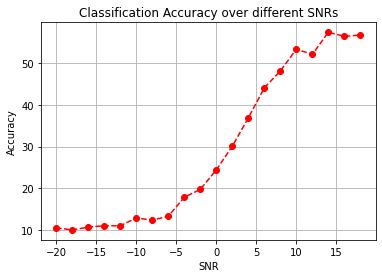

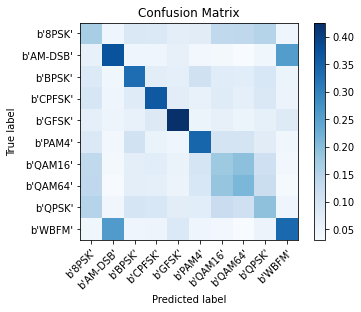

In [ ]:
print(print_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_valid[:,0]), LB().fit_transform(y_pred_valid), mods)

In [ ]:
print("Prediction test:", y_pred_test)
print("true test", y_test[:,0])
acc = accuracy_score(y_test[:,0], y_pred_test)
print("Accuracy test", acc)

Prediction test: [b'PAM4' b'8PSK' b'BPSK' ... b'8PSK' b'QAM64' b'CPFSK']
true test [b'QAM64' b'QAM16' b'CPFSK' ... b'BPSK' b'QAM16' b'CPFSK']
Accuracy test 0.2907


           -20    -18   -16    -14    -12  ...     10    12     14    16     18
accuracy  9.58  10.25  9.78  10.18  10.47  ...  51.96  54.0  55.16  56.0  55.71

[1 rows x 20 columns]


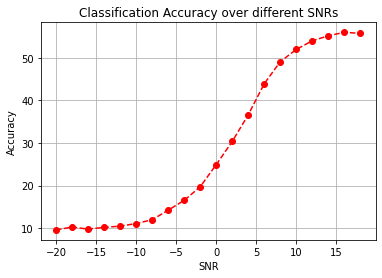

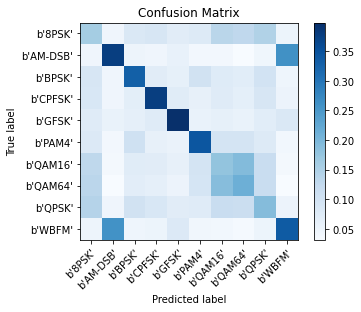

In [ ]:
print(print_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_test[:,0]), LB().fit_transform(y_pred_test), mods)

###Random Forest 



In [ ]:
rfc=RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rfc.fit(x_train2,y_train[:,0])
y_pred_valid =rfc.predict(x_valid2)
y_pred_test=rfc.predict(x_test2)
del rfc

####Evaluation

In [ ]:
print("Prediction validation:", y_pred_valid)
print("true validation", y_valid[:,0])
acc = accuracy_score(y_valid[:,0], y_pred_valid)
print("Accuracy validation", acc)

Prediction validation: [b'BPSK' b'WBFM' b'CPFSK' ... b'QPSK' b'BPSK' b'CPFSK']
true validation [b'8PSK' b'AM-DSB' b'CPFSK' ... b'8PSK' b'QPSK' b'CPFSK']
Accuracy validation 0.3661904761904762


           -20    -18   -16    -14    -12  ...     10     12    14     16     18
accuracy  9.92  10.58  10.6  10.25  10.17  ...  56.95  55.47  56.8  56.28  56.34

[1 rows x 20 columns]


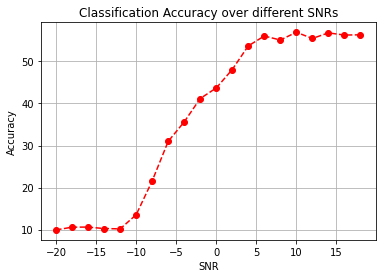

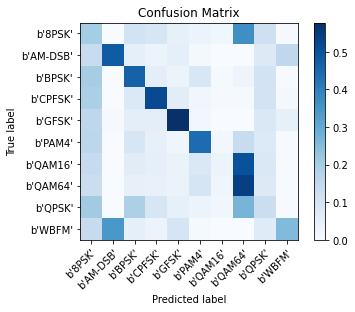

In [ ]:
print(print_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_valid[:,0]), LB().fit_transform(y_pred_valid), mods)

In [ ]:
print("Prediction test:", y_pred_test)
print("true test", y_test[:,0])
acc = accuracy_score(y_test[:,0], y_pred_test)
print("Accuracy test", acc)

Prediction test: [b'PAM4' b'QPSK' b'8PSK' ... b'PAM4' b'PAM4' b'CPFSK']
true test [b'QAM64' b'QAM16' b'CPFSK' ... b'BPSK' b'QAM16' b'CPFSK']
Accuracy test 0.36723333333333336


            -20    -18    -16    -14   -12  ...     10     12     14     16     18
accuracy  10.14  10.49  10.26  10.35  11.0  ...  55.69  56.06  56.29  56.39  55.97

[1 rows x 20 columns]


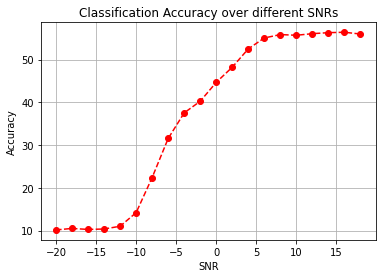

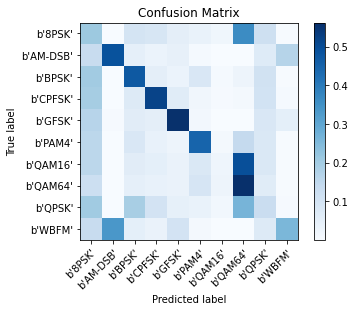

In [ ]:
print(print_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_test[:,0]), LB().fit_transform(y_pred_test), mods)

###Fully Connected Dense Layer



In [ ]:
model = keras.Sequential()
model.add(layers.Dense(256, activation= "relu", name= "dense1",kernel_regularizer='l2', input_shape= (4, 128)))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation ='softmax')) #10 classes
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 4, 256)            33024     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                10250     
Total params: 43,274
Trainable params: 43,274
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 200
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
history = model.fit(
    X_train,
    Y_train,
    batch_size = 400,
    validation_split = 0.05,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/200
1995/1995 [==============================] - 10s 4ms/step - loss: 2.1952 - accuracy: 0.2334 - val_loss: 1.8541 - val_accuracy: 0.3112
Epoch 2/200
1995/1995 [==============================] - 5s 3ms/step - loss: 1.8307 - accuracy: 0.3160 - val_loss: 1.8075 - val_accuracy: 0.3185
Epoch 3/200
1995/1995 [==============================] - 5s 3ms/step - loss: 1.7915 - accuracy: 0.3287 - val_loss: 1.7836 - val_accuracy: 0.3288
Epoch 4/200
1995/1995 [==============================] - 8s 4ms/step - loss: 1.7733 - accuracy: 0.3317 - val_loss: 1.7708 - val_accuracy: 0.3305
Epoch 5/200
1995/1995 [==============================] - 8s 4ms/step - loss: 1.7612 - accuracy: 0.3335 - val_loss: 1.7616 - val_accuracy: 0.3336
Epoch 6/200
1995/1995 [==============================] - 8s 4ms/step - loss: 1.7525 - accuracy: 0.3360 - val_loss: 1.7602 - val_accuracy: 0.3316
Epoch 7/200
1995/1995 [==============================] - 8s 4ms/step - loss: 1.7473 - accuracy: 0.3378 - val_loss: 1.7508 - val_a

####Evaluation

In [ ]:
results = model.evaluate(X_test, Y_test, batch_size=400)
y_pred_test = model.predict(X_test)
print("test loss, test acc:", results)

900/900 [==============================] - 2s 2ms/step - loss: 1.6529 - accuracy: 0.3652
test loss, test acc: [1.6529204845428467, 0.36523333191871643]


            -20    -18    -16    -14   -12  ...     10     12     14     16     18
accuracy  10.12  10.93  11.59  13.09  15.5  ...  48.96  48.68  49.29  48.58  49.32

[1 rows x 20 columns]


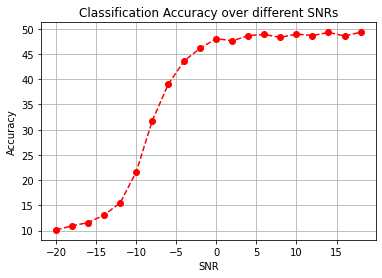

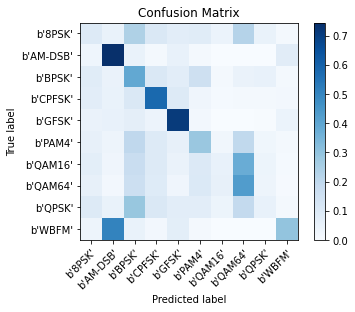

In [ ]:
print(print_results(y_pred_test,  Y_test, snr_test))
plot_results(y_pred_test,  Y_test, snr_test)
plot_confusion_matrix(Y_test, y_pred_test, mods)

###CNN Model

In [ ]:
del model
from tensorflow.keras import layers
def cnn_model():
  #model = keras.Sequential()
  input_img = layers.Input(shape=(4, 128, 1), name="image")
  x = layers.Conv2D(64,(1,3), activation="relu", name="Conv1")(input_img)
  x = layers.Conv2D(16,(2,3),  activation="relu", name="Conv2")(x)
  x = layers.Flatten(name = 'flattened_img')(x)
  x = layers.Dense(128, activation="relu", name="dense1")(x)
  x = layers.Dense(10, activation="softmax", name="dense2")(x)
  model = keras.models.Model(inputs=[input_img], outputs=x, name="cnn_model")
  return model

In [ ]:
model_cnn = cnn_model()
model_cnn.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 4, 128, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 4, 126, 64)        256       
_________________________________________________________________
Conv2 (Conv2D)               (None, 3, 124, 16)        6160      
_________________________________________________________________
flattened_img (Flatten)      (None, 5952)              0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               761984    
_________________________________________________________________
dense2 (Dense)               (None, 10)                1290      
Total params: 769,690
Trainable params: 769,690
Non-trainable params: 0
___________________________________________________

In [ ]:
model_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])
epochs = 200
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
history = model_cnn.fit(
    X_train,
    Y_train,
    batch_size = 400,
    validation_split = 0.05,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/200
1995/1995 [==============================] - 26s 10ms/step - loss: 1.5600 - accuracy: 0.3708 - val_loss: 1.1751 - val_accuracy: 0.5011
Epoch 2/200
1995/1995 [==============================] - 19s 9ms/step - loss: 1.1504 - accuracy: 0.5111 - val_loss: 1.1273 - val_accuracy: 0.5105
Epoch 3/200
1995/1995 [==============================] - 18s 9ms/step - loss: 1.1042 - accuracy: 0.5295 - val_loss: 1.1101 - val_accuracy: 0.5291
Epoch 4/200
1995/1995 [==============================] - 18s 9ms/step - loss: 1.0766 - accuracy: 0.5452 - val_loss: 1.0846 - val_accuracy: 0.5389
Epoch 5/200
1995/1995 [==============================] - 18s 9ms/step - loss: 1.0431 - accuracy: 0.5623 - val_loss: 1.0684 - val_accuracy: 0.5495
Epoch 6/200
1995/1995 [==============================] - 18s 9ms/step - loss: 1.0152 - accuracy: 0.5754 - val_loss: 1.0636 - val_accuracy: 0.5517
Epoch 7/200
1995/1995 [==============================] - 18s 9ms/step - loss: 0.9860 - accuracy: 0.5892 - val_loss: 1.0550 

####Evaluation

In [ ]:
results = model_cnn.evaluate(X_test, Y_test, batch_size=400)
y_pred_test = model_cnn.predict(X_test)
print("test loss, test acc:", results)

900/900 [==============================] - 4s 4ms/step - loss: 1.0549 - accuracy: 0.5586
test loss, test acc: [1.0548757314682007, 0.55860835313797]


            -20    -18    -16    -14    -12  ...     10     12     14     16     18
accuracy  10.36  10.92  11.98  15.67  21.07  ...  81.95  81.85  82.02  81.76  82.28

[1 rows x 20 columns]


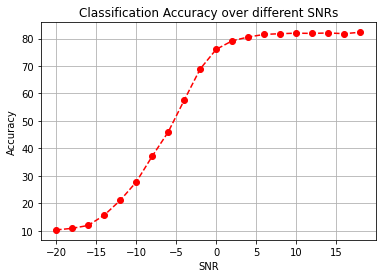

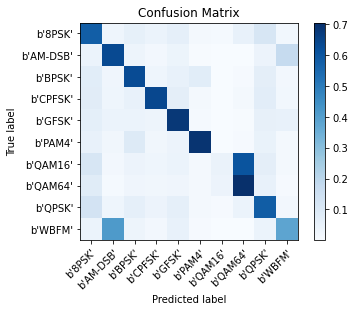

In [ ]:
print(print_results(y_pred_test,  Y_test, snr_test))
plot_results(y_pred_test,  Y_test, snr_test)
plot_confusion_matrix(Y_test, y_pred_test, mods)

# **Combinations of Raw and integral**

##Feature Spaces

In [ ]:
del Xd
print(X.shape)
raw = normalize(X[:,0]), normalize(X[:,1])
integral = normalize(np.cumsum(X[:,0], axis = 1)), normalize(np.cumsum(X[:,1], axis = 1))
print('Finish')
com_feature = raw
com_feature += integral
del X
del raw
del integral
com_feature = np.stack(com_feature, axis = 1)
print(com_feature)
print(com_feature.shape)
lbl = np.array(lbl)

(1200000, 2, 128)
Finish
[[[ 0.12533608  0.0828359  -0.049265   ... -0.0325529  -0.01167205
    0.05498357]
  [-0.00755202  0.11155538  0.0904377  ... -0.08977888 -0.10727949
   -0.10767834]
  [ 0.01147853  0.01906481  0.01455302 ...  0.15236448  0.15129553
    0.15633103]
  [-0.00155472  0.02141102  0.04002929 ... -0.02201433 -0.0440998
   -0.06626738]]

 [[-0.06435594 -0.1615047  -0.10427034 ... -0.13816652 -0.04033643
   -0.07967182]
  [ 0.1242578  -0.13422264  0.01408419 ...  0.0225845  -0.01648061
    0.0780423 ]
  [-0.00615713 -0.02160878 -0.03158464 ... -0.14844999 -0.1523091
   -0.15993154]
  [ 0.01931132 -0.00154867  0.0006402  ...  0.13048658  0.12792528
    0.14005409]]

 [[ 0.0245417  -0.11838678  0.0206798  ... -0.09036851  0.07068066
    0.30245152]
  [-0.01437539 -0.04870061 -0.01036766 ...  0.02849814 -0.003336
    0.04634549]
  [ 0.00813042 -0.03108993 -0.02423892 ... -0.08297462 -0.05955883
    0.04064029]
  [-0.00561907 -0.02465524 -0.02870776 ... -0.05373027 -0.0550

**Helped_Link:** [Feature_Spaces](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html?fbclid=IwAR0VVCxswWf71tGfxfNENX7sX_DUS3hIIHrqBfuq2loHN22st8THrzfeHVM)

##Spliting DataSet

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(com_feature, lbl, test_size=0.3)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(840000, 4, 128) (840000, 2) (360000, 4, 128) (360000, 2)


In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train , y_train, test_size=0.05)
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(798000, 4, 128) (798000, 2) (42000, 4, 128) (42000, 2)


In [ ]:
nsamples, nx, ny = x_train.shape
x_train2 = x_train.reshape((nsamples, nx*ny))
nsamples, nx, ny = x_test.shape
x_test2 = x_test.reshape((nsamples, nx*ny))
nsamples, nx, ny = x_valid.shape
x_valid2 = x_valid.reshape((nsamples, nx*ny))
del x_train
del x_valid
del x_test
del com_feature
del lbl

In [ ]:
import random
n_examples = com_feature.shape[0]
n_train = n_examples * 0.7
#a = range(0,n_examples)
train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = com_feature[train_idx]
X_test =  com_feature[test_idx]
Y_train = LB().fit_transform(lbl[train_idx][:,0])
Y_test = LB().fit_transform(lbl[test_idx][:,0])
snr_train = lbl[train_idx][:,1].astype(int)
snr_test = lbl[test_idx][:,1].astype(int)
del lbl
del com_feature

In [ ]:
print(X_train.shape,X_test.shape, Y_train.shape, Y_test.shape)

(840000, 4, 128) (360000, 4, 128) (840000, 10) (360000, 10)


##Classifiers



###Logistic Regression

In [ ]:
lr = LogisticRegression()
lr = lr.fit(x_train2, y_train[:,0])
y_pred_valid = lr.predict(x_valid2)
y_pred_test = lr.predict(x_test2)
del lr

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


####Evaluation

In [ ]:
print("Prediction validation:", y_pred_valid)
print("true validation", y_valid[:,0])
acc = accuracy_score(y_valid[:,0], y_pred_valid)
print("Accuracy validation", acc)

Prediction validation: [b'AM-DSB' b'WBFM' b'PAM4' ... b'WBFM' b'BPSK' b'BPSK']
true validation [b'AM-DSB' b'AM-DSB' b'AM-DSB' ... b'AM-DSB' b'QAM64' b'QAM64']
Accuracy validation 0.16580952380952382


           -20   -18    -16   -14    -12  ...     10     12     14     16     18
accuracy  9.57  9.51  10.34  10.1  10.69  ...  19.15  21.07  19.43  18.31  18.24

[1 rows x 20 columns]


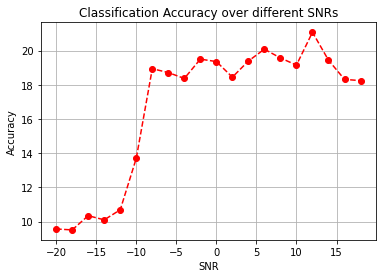

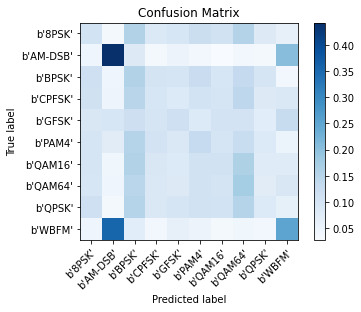

In [ ]:
print(print_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_valid[:,0]), LB().fit_transform(y_pred_valid), mods)

In [ ]:
print("Prediction test:", y_pred_test)
print("true test", y_test[:,0])
acc = accuracy_score(y_test[:,0], y_pred_test)
print("Accuracy test", acc)

Prediction test: [b'QAM16' b'GFSK' b'GFSK' ... b'AM-DSB' b'CPFSK' b'CPFSK']
true test [b'CPFSK' b'BPSK' b'8PSK' ... b'WBFM' b'WBFM' b'QAM16']
Accuracy test 0.16429166666666667


            -20    -18    -16   -14    -12  ...     10     12     14     16     18
accuracy  10.07  10.26  10.29  11.0  11.17  ...  18.84  18.65  19.16  19.28  18.76

[1 rows x 20 columns]


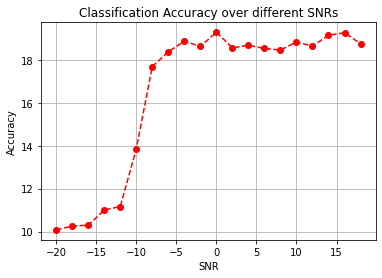

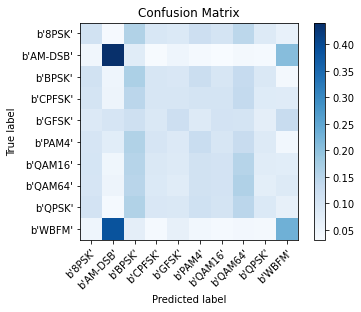

In [ ]:
print(print_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_test[:,0]), LB().fit_transform(y_pred_test), mods)

###Decision Tree



In [ ]:
dr = tree.DecisionTreeClassifier()
dr = dr.fit(x_train2, y_train[:,0])
y_pred_valid = dr.predict(x_valid2)
y_pred_test = dr.predict(x_test2)
del dr

####Evaluation

In [ ]:
print("Prediction validation:", y_pred_valid)
print("true validation", y_valid[:,0])
acc = accuracy_score(y_valid[:,0], y_pred_valid)
print("Accuracy validation", acc)

Prediction validation: [b'AM-DSB' b'WBFM' b'CPFSK' ... b'AM-DSB' b'QPSK' b'BPSK']
true validation [b'AM-DSB' b'AM-DSB' b'AM-DSB' ... b'AM-DSB' b'QAM64' b'QAM64']
Accuracy validation 0.2781190476190476


          -20    -18    -16    -14   -12  ...     10     12     14     16    18
accuracy  9.8  10.26  10.07  11.01  11.6  ...  45.33  48.64  46.97  46.93  46.1

[1 rows x 20 columns]


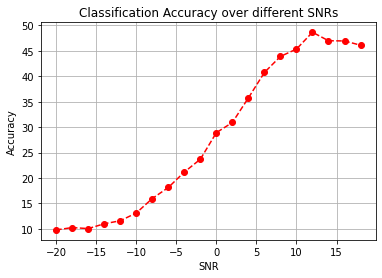

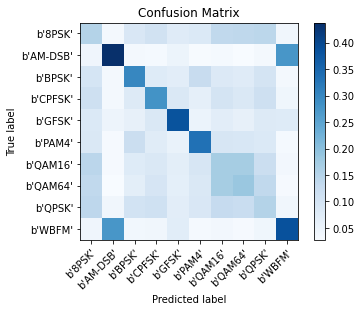

In [ ]:
print(print_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_valid[:,0]), LB().fit_transform(y_pred_valid), mods)

In [ ]:
print("Prediction test:", y_pred_test)
print("true test", y_test[:,0])
acc = accuracy_score(y_test[:,0], y_pred_test)
print("Accuracy test", acc)

Prediction test: [b'QAM16' b'BPSK' b'8PSK' ... b'AM-DSB' b'QPSK' b'PAM4']
true test [b'CPFSK' b'BPSK' b'8PSK' ... b'WBFM' b'WBFM' b'QAM16']
Accuracy test 0.28076666666666666


           -20    -18    -16   -14    -12  ...     10     12     14     16     18
accuracy  9.72  10.43  10.62  11.0  11.38  ...  45.84  46.43  47.45  48.06  47.41

[1 rows x 20 columns]


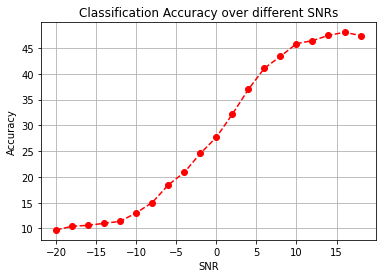

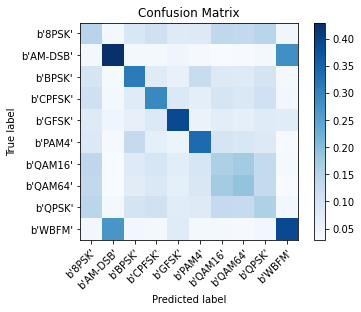

In [ ]:
print(print_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_test[:,0]), LB().fit_transform(y_pred_test), mods)

###Random Forest 



In [ ]:
rfc=RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rfc.fit(x_train2,y_train[:,0])
y_pred_valid =rfc.predict(x_valid2)
y_pred_test=rfc.predict(x_test2)
del rfc

####Evaluation

In [ ]:
print("Prediction validation:", y_pred_valid)
print("true validation", y_valid[:,0])
acc = accuracy_score(y_valid[:,0], y_pred_valid)
print("Accuracy validation", acc)

Prediction validation: [b'AM-DSB' b'WBFM' b'8PSK' ... b'WBFM' b'PAM4' b'BPSK']
true validation [b'AM-DSB' b'AM-DSB' b'AM-DSB' ... b'AM-DSB' b'QAM64' b'QAM64']
Accuracy validation 0.3300952380952381


            -20    -18    -16    -14    -12  ...     10     12    14     16    18
accuracy  10.13  10.82  10.58  12.21  13.75  ...  48.35  50.33  48.1  48.66  48.0

[1 rows x 20 columns]


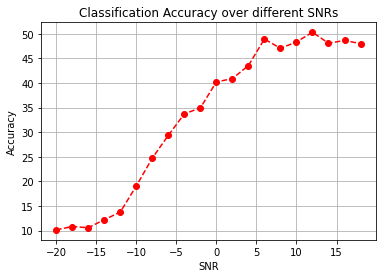

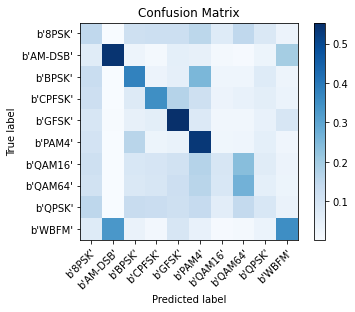

In [ ]:
print(print_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_valid[:,0]), LB().fit_transform(y_pred_valid), mods)

In [ ]:
print("Prediction test:", y_pred_test)
print("true test", y_test[:,0])
acc = accuracy_score(y_test[:,0], y_pred_test)
print("Accuracy test", acc)

Prediction test: [b'BPSK' b'BPSK' b'QAM64' ... b'AM-DSB' b'PAM4' b'PAM4']
true test [b'CPFSK' b'BPSK' b'8PSK' ... b'WBFM' b'WBFM' b'QAM16']
Accuracy test 0.3310666666666667


            -20    -18    -16    -14   -12  ...     10     12     14     16     18
accuracy  10.27  10.52  10.82  12.34  13.7  ...  47.96  48.06  48.64  48.09  47.86

[1 rows x 20 columns]


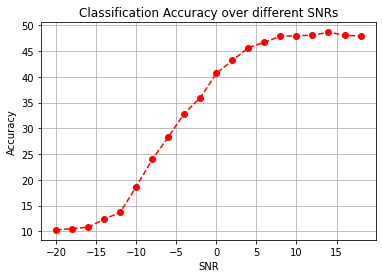

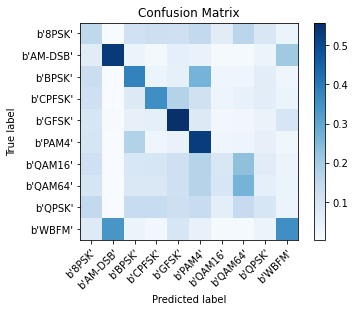

In [ ]:
print(print_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_test[:,0]), LB().fit_transform(y_pred_test), mods)

###Fully Connected Dense Layer



In [ ]:
model = keras.Sequential()
model.add(layers.Dense(256, activation= "relu", name= "dense1",kernel_regularizer='l2', input_shape= (4, 128)))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation ='softmax')) #10 classes
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 4, 256)            33024     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                10250     
Total params: 43,274
Trainable params: 43,274
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 200
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
history = model.fit(
    X_train,
    Y_train,
    batch_size = 400,
    validation_split = 0.05,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/200
1995/1995 [==============================] - 8s 3ms/step - loss: 2.2190 - accuracy: 0.2186 - val_loss: 1.8832 - val_accuracy: 0.2971
Epoch 2/200
1995/1995 [==============================] - 5s 3ms/step - loss: 1.8693 - accuracy: 0.3045 - val_loss: 1.8315 - val_accuracy: 0.3148
Epoch 3/200
1995/1995 [==============================] - 5s 3ms/step - loss: 1.8250 - accuracy: 0.3208 - val_loss: 1.8049 - val_accuracy: 0.3222
Epoch 4/200
1995/1995 [==============================] - 5s 3ms/step - loss: 1.8031 - accuracy: 0.3230 - val_loss: 1.7925 - val_accuracy: 0.3235
Epoch 5/200
1995/1995 [==============================] - 5s 3ms/step - loss: 1.7913 - accuracy: 0.3240 - val_loss: 1.7853 - val_accuracy: 0.3229
Epoch 6/200
1995/1995 [==============================] - 5s 3ms/step - loss: 1.7824 - accuracy: 0.3262 - val_loss: 1.7777 - val_accuracy: 0.3267
Epoch 7/200
1995/1995 [==============================] - 5s 3ms/step - loss: 1.7744 - accuracy: 0.3280 - val_loss: 1.7738 - val_ac

####Evaluation

In [ ]:
results = model.evaluate(X_test, Y_test, batch_size=400)
y_pred_test = model.predict(X_test)
print("test loss, test acc:", results)

900/900 [==============================] - 2s 2ms/step - loss: 1.7312 - accuracy: 0.3343
test loss, test acc: [1.7312359809875488, 0.33434444665908813]


            -20   -18    -16    -14    -12  ...     10     12     14    16     18
accuracy  10.48  11.3  11.47  12.87  15.37  ...  41.71  41.59  41.86  41.6  41.51

[1 rows x 20 columns]


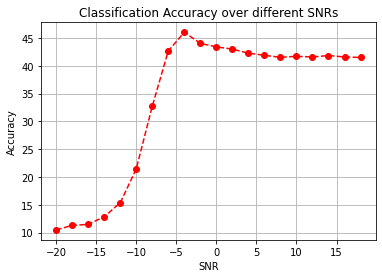

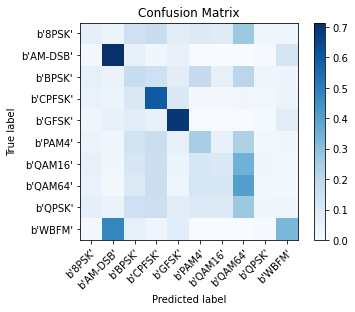

In [ ]:
print(print_results(y_pred_test,  Y_test, snr_test))
plot_results(y_pred_test,  Y_test, snr_test)
plot_confusion_matrix(Y_test, y_pred_test, mods)

###CNN Model

In [ ]:
del model
from tensorflow.keras import layers
def cnn_model():
  #model = keras.Sequential()
  input_img = layers.Input(shape=(4, 128, 1), name="image")
  x = layers.Conv2D(64,(1,3), activation="relu", name="Conv1")(input_img)
  x = layers.Conv2D(16,(2,3),  activation="relu", name="Conv2")(x)
  x = layers.Flatten(name = 'flattened_img')(x)
  x = layers.Dense(128, activation="relu", name="dense1")(x)
  x = layers.Dense(10, activation="softmax", name="dense2")(x)
  model = keras.models.Model(inputs=[input_img], outputs=x, name="cnn_model")
  return model

In [ ]:
model_cnn = cnn_model()
model_cnn.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 4, 128, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 4, 126, 64)        256       
_________________________________________________________________
Conv2 (Conv2D)               (None, 3, 124, 16)        6160      
_________________________________________________________________
flattened_img (Flatten)      (None, 5952)              0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               761984    
_________________________________________________________________
dense2 (Dense)               (None, 10)                1290      
Total params: 769,690
Trainable params: 769,690
Non-trainable params: 0
___________________________________________________

In [ ]:
model_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])
epochs = 200
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
history = model_cnn.fit(
    X_train,
    Y_train,
    batch_size = 400,
    validation_split = 0.05,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/200
1995/1995 [==============================] - 25s 9ms/step - loss: 1.6598 - accuracy: 0.3438 - val_loss: 1.2325 - val_accuracy: 0.4927
Epoch 2/200
1995/1995 [==============================] - 19s 9ms/step - loss: 1.2172 - accuracy: 0.4953 - val_loss: 1.1754 - val_accuracy: 0.5145
Epoch 3/200
1995/1995 [==============================] - 19s 9ms/step - loss: 1.1334 - accuracy: 0.5282 - val_loss: 1.1094 - val_accuracy: 0.5369
Epoch 4/200
1995/1995 [==============================] - 18s 9ms/step - loss: 1.1028 - accuracy: 0.5377 - val_loss: 1.1134 - val_accuracy: 0.5330
Epoch 5/200
1995/1995 [==============================] - 18s 9ms/step - loss: 1.0856 - accuracy: 0.5431 - val_loss: 1.0869 - val_accuracy: 0.5411
Epoch 6/200
1995/1995 [==============================] - 18s 9ms/step - loss: 1.0718 - accuracy: 0.5486 - val_loss: 1.0880 - val_accuracy: 0.5345
Epoch 7/200
1995/1995 [==============================] - 18s 9ms/step - loss: 1.0592 - accuracy: 0.5549 - val_loss: 1.0786 -

####Evaluation

In [ ]:
results = model_cnn.evaluate(X_test, Y_test, batch_size=400)
y_pred_test = model_cnn.predict(X_test)
print("test loss, test acc:", results)

900/900 [==============================] - 4s 4ms/step - loss: 1.0815 - accuracy: 0.5476
test loss, test acc: [1.0815238952636719, 0.547594428062439]


            -20    -18    -16   -14    -12  ...     10     12     14     16     18
accuracy  10.25  11.03  12.05  14.5  18.44  ...  80.77  80.04  80.88  80.23  80.48

[1 rows x 20 columns]


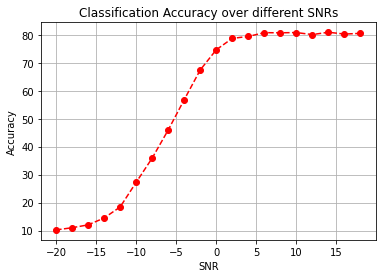

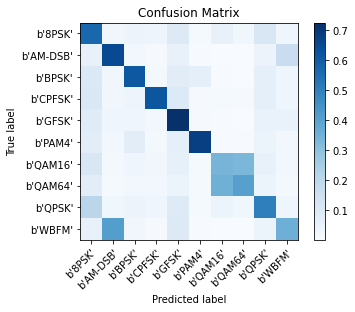

In [ ]:
print(print_results(y_pred_test,  Y_test, snr_test))
plot_results(y_pred_test,  Y_test, snr_test)
plot_confusion_matrix(Y_test, y_pred_test, mods)

# **Combinations of derivative and integral**

##Feature Spaces

In [ ]:
del Xd
print(X.shape)
integral = normalize(np.cumsum(X[:,0], axis = 1)), normalize(np.cumsum(X[:,1], axis = 1))
derivative = normalize(np.gradient(X[:,0], axis = 1)), normalize(np.gradient(X[:,1], axis = 1))
print('Finish')
com_feature = integral
com_feature += derivative
del X
del derivative
del integral
com_feature = np.stack(com_feature, axis = 1)
print(com_feature)
print(com_feature.shape)
lbl = np.array(lbl)

(1200000, 2, 128)
Finish
[[[ 0.01147853  0.01906481  0.01455302 ...  0.15236448  0.15129553
    0.15633103]
  [-0.00155472  0.02141102  0.04002929 ... -0.02201433 -0.0440998
   -0.06626738]
  [-0.06029993 -0.12386337 -0.01638079 ... -0.0186449   0.06209905
    0.09457203]
  [ 0.16911437  0.06956524 -0.03776356 ... -0.23020586 -0.01270726
   -0.0005663 ]]

 [[-0.00615713 -0.02160878 -0.03158464 ... -0.14844999 -0.1523091
   -0.15993154]
  [ 0.01931132 -0.00154867  0.0006402  ...  0.13048658  0.12792528
    0.14005409]
  [-0.13455155 -0.02764083  0.00650999 ... -0.0411226   0.04050773
   -0.05447972]
  [-0.34514645 -0.07355688  0.1361285  ... -0.02114303  0.03702613
    0.12621552]]

 [[ 0.00813042 -0.03108993 -0.02423892 ... -0.08297462 -0.05955883
    0.04064029]
  [-0.00561907 -0.02465524 -0.02870776 ... -0.05373027 -0.05503425
   -0.03691867]
  [-0.18550996 -0.00250622 -0.02935102 ...  0.06251812  0.2549248
    0.3008204 ]
  [-0.0445585   0.00260127  0.01163624 ... -0.06970791  0.011

**Helped_Link:** [Feature_Spaces](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html?fbclid=IwAR0VVCxswWf71tGfxfNENX7sX_DUS3hIIHrqBfuq2loHN22st8THrzfeHVM)

##Spliting DataSet

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(com_feature, lbl, test_size=0.3)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(840000, 4, 128) (840000, 2) (360000, 4, 128) (360000, 2)


In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train , y_train, test_size=0.05)
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(798000, 4, 128) (798000, 2) (42000, 4, 128) (42000, 2)


In [ ]:
nsamples, nx, ny = x_train.shape
x_train2 = x_train.reshape((nsamples, nx*ny))
nsamples, nx, ny = x_test.shape
x_test2 = x_test.reshape((nsamples, nx*ny))
nsamples, nx, ny = x_valid.shape
x_valid2 = x_valid.reshape((nsamples, nx*ny))
del x_train
del x_valid
del x_test
del com_feature
del lbl

In [ ]:
import random
n_examples = com_feature.shape[0]
n_train = n_examples * 0.7
#a = range(0,n_examples)
train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = com_feature[train_idx]
X_test =  com_feature[test_idx]
Y_train = LB().fit_transform(lbl[train_idx][:,0])
Y_test = LB().fit_transform(lbl[test_idx][:,0])
snr_train = lbl[train_idx][:,1].astype(int)
snr_test = lbl[test_idx][:,1].astype(int)
del lbl
del com_feature

In [ ]:
print(X_train.shape,X_test.shape, Y_train.shape, Y_test.shape)

(840000, 4, 128) (360000, 4, 128) (840000, 10) (360000, 10)


##Classifiers



###Logistic Regression

In [ ]:
lr = LogisticRegression()
lr = lr.fit(x_train2, y_train[:,0])
y_pred_valid = lr.predict(x_valid2)
y_pred_test = lr.predict(x_test2)
del lr

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


####Evaluation

In [ ]:
print("Prediction validation:", y_pred_valid)
print("true validation", y_valid[:,0])
acc = accuracy_score(y_valid[:,0], y_pred_valid)
print("Accuracy validation", acc)

Prediction validation: [b'CPFSK' b'BPSK' b'WBFM' ... b'QPSK' b'WBFM' b'WBFM']
true validation [b'QAM16' b'8PSK' b'CPFSK' ... b'GFSK' b'QAM16' b'QAM64']
Accuracy validation 0.15323809523809523


            -20    -18    -16    -14    -12  ...     10     12     14     16     18
accuracy  10.94  11.17  11.65  12.24  12.63  ...  17.02  15.55  19.52  16.55  17.31

[1 rows x 20 columns]


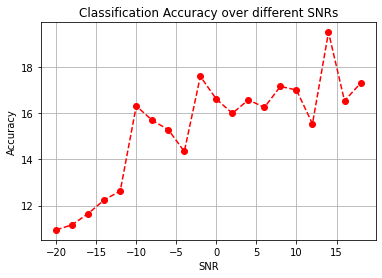

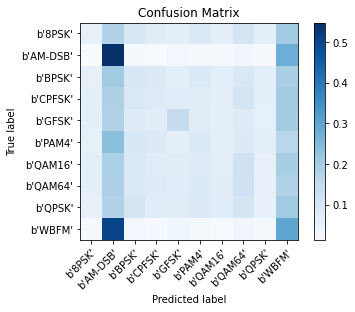

In [ ]:
print(print_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_valid[:,0]), LB().fit_transform(y_pred_valid), mods)

In [ ]:
print("Prediction test:", y_pred_test)
print("true test", y_test[:,0])
acc = accuracy_score(y_test[:,0], y_pred_test)
print("Accuracy test", acc)

Prediction test: [b'QAM16' b'PAM4' b'QAM64' ... b'GFSK' b'QPSK' b'PAM4']
true test [b'QPSK' b'QAM64' b'GFSK' ... b'AM-DSB' b'BPSK' b'QAM64']
Accuracy test 0.15668888888888888


            -20    -18    -16   -14    -12  ...     10     12     14     16     18
accuracy  10.99  11.33  11.63  13.1  14.25  ...  18.13  17.71  18.18  17.85  17.42

[1 rows x 20 columns]


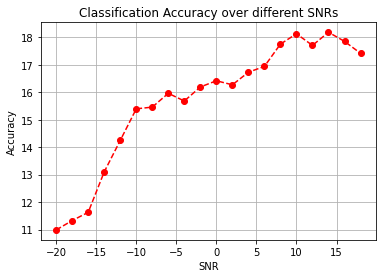

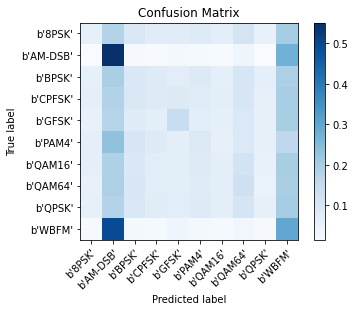

In [ ]:
print(print_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_test[:,0]), LB().fit_transform(y_pred_test), mods)

###Decision Tree



In [ ]:
dr = tree.DecisionTreeClassifier()
dr = dr.fit(x_train2, y_train[:,0])
y_pred_valid = dr.predict(x_valid2)
y_pred_test = dr.predict(x_test2)
del dr

####Evaluation

In [ ]:
print("Prediction validation:", y_pred_valid)
print("true validation", y_valid[:,0])
acc = accuracy_score(y_valid[:,0], y_pred_valid)
print("Accuracy validation", acc)

Prediction validation: [b'BPSK' b'QAM16' b'GFSK' ... b'CPFSK' b'8PSK' b'QPSK']
true validation [b'QAM16' b'8PSK' b'CPFSK' ... b'GFSK' b'QAM16' b'QAM64']
Accuracy validation 0.2490952380952381


          -20    -18   -16    -14    -12  ...     10     12     14     16     18
accuracy  9.6  10.58  9.66  10.38  10.28  ...  37.12  39.68  41.52  39.57  41.47

[1 rows x 20 columns]


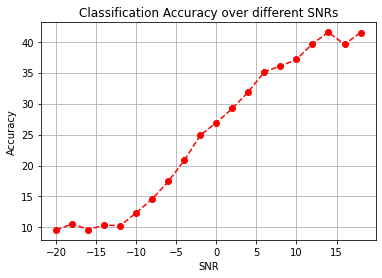

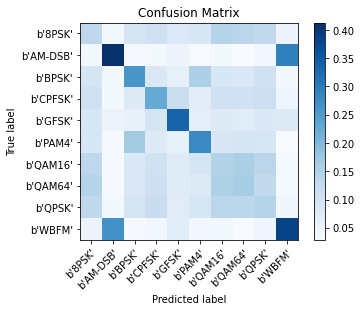

In [ ]:
print(print_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_valid[:,0]), LB().fit_transform(y_pred_valid), mods)

In [ ]:
print("Prediction test:", y_pred_test)
print("true test", y_test[:,0])
acc = accuracy_score(y_test[:,0], y_pred_test)
print("Accuracy test", acc)

Prediction test: [b'QPSK' b'GFSK' b'GFSK' ... b'GFSK' b'QPSK' b'QAM64']
true test [b'QPSK' b'QAM64' b'GFSK' ... b'AM-DSB' b'BPSK' b'QAM64']
Accuracy test 0.25256666666666666


           -20    -18    -16    -14    -12  ...     10     12    14    16     18
accuracy  9.73  10.04  10.32  11.03  11.45  ...  38.55  39.63  40.8  41.5  39.97

[1 rows x 20 columns]


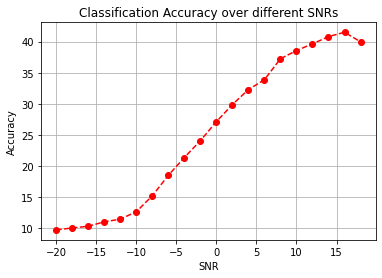

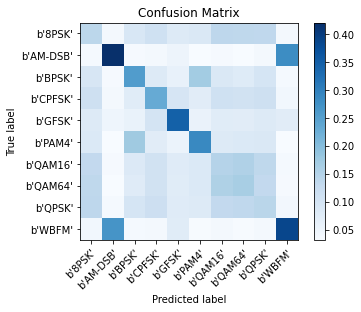

In [ ]:
print(print_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_test[:,0]), LB().fit_transform(y_pred_test), mods)

###Random Forest 



In [ ]:
rfc=RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rfc.fit(x_train2,y_train[:,0])
y_pred_valid =rfc.predict(x_valid2)
y_pred_test=rfc.predict(x_test2)
del rfc

####Evaluation

In [ ]:
print("Prediction validation:", y_pred_valid)
print("true validation", y_valid[:,0])
acc = accuracy_score(y_valid[:,0], y_pred_valid)
print("Accuracy validation", acc)

Prediction validation: [b'GFSK' b'QAM64' b'GFSK' ... b'8PSK' b'8PSK' b'GFSK']
true validation [b'QAM16' b'8PSK' b'CPFSK' ... b'GFSK' b'QAM16' b'QAM64']
Accuracy validation 0.2967142857142857


           -20    -18    -16   -14    -12  ...     10    12     14     16     18
accuracy  9.79  10.24  11.04  12.2  14.66  ...  40.08  42.0  40.81  41.49  39.92

[1 rows x 20 columns]


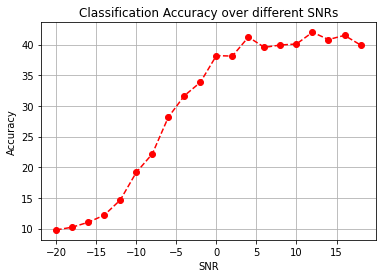

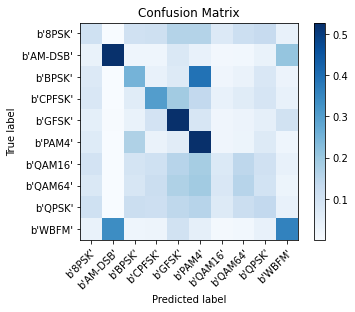

In [ ]:
print(print_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_valid[:,0]), LB().fit_transform(y_pred_valid), mods)

In [ ]:
print("Prediction test:", y_pred_test)
print("true test", y_test[:,0])
acc = accuracy_score(y_test[:,0], y_pred_test)
print("Accuracy test", acc)

Prediction test: [b'BPSK' b'CPFSK' b'GFSK' ... b'GFSK' b'PAM4' b'BPSK']
true test [b'QPSK' b'QAM64' b'GFSK' ... b'AM-DSB' b'BPSK' b'QAM64']
Accuracy test 0.29673055555555555


           -20    -18    -16    -14    -12  ...     10     12     14     16     18
accuracy  10.1  10.68  11.22  11.92  13.78  ...  41.28  41.59  42.38  41.98  41.22

[1 rows x 20 columns]


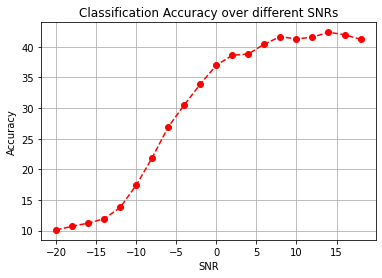

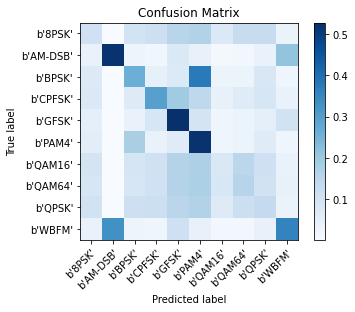

In [ ]:
print(print_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_test[:,0]), LB().fit_transform(y_pred_test), mods)

###Fully Connected Dense Layer



In [ ]:
model = keras.Sequential()
model.add(layers.Dense(256, activation= "relu", name= "dense1",kernel_regularizer='l2', input_shape= (4, 128)))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation ='softmax')) #10 classes
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 4, 256)            33024     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                10250     
Total params: 43,274
Trainable params: 43,274
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 200
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
history = model.fit(
    X_train,
    Y_train,
    batch_size = 400,
    validation_split = 0.05,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/200
1995/1995 [==============================] - 9s 3ms/step - loss: 2.2787 - accuracy: 0.2095 - val_loss: 1.9537 - val_accuracy: 0.2750
Epoch 2/200
1995/1995 [==============================] - 7s 3ms/step - loss: 1.9407 - accuracy: 0.2821 - val_loss: 1.9047 - val_accuracy: 0.3018
Epoch 3/200
1995/1995 [==============================] - 11s 6ms/step - loss: 1.8997 - accuracy: 0.2966 - val_loss: 1.8795 - val_accuracy: 0.3015
Epoch 4/200
1995/1995 [==============================] - 12s 6ms/step - loss: 1.8769 - accuracy: 0.3040 - val_loss: 1.8732 - val_accuracy: 0.3101
Epoch 5/200
1995/1995 [==============================] - 12s 6ms/step - loss: 1.8637 - accuracy: 0.3077 - val_loss: 1.8570 - val_accuracy: 0.3051
Epoch 6/200
1995/1995 [==============================] - 12s 6ms/step - loss: 1.8540 - accuracy: 0.3096 - val_loss: 1.8467 - val_accuracy: 0.3102
Epoch 7/200
1995/1995 [==============================] - 11s 6ms/step - loss: 1.8487 - accuracy: 0.3105 - val_loss: 1.8419 - v

####Evaluation

In [ ]:
results = model.evaluate(X_test, Y_test, batch_size=400)
y_pred_test = model.predict(X_test)
print("test loss, test acc:", results)

900/900 [==============================] - 2s 2ms/step - loss: 1.7572 - accuracy: 0.3331
test loss, test acc: [1.7572215795516968, 0.33314165472984314]


            -20   -18    -16    -14    -12  ...     10     12     14     16     18
accuracy  11.03  10.8  11.33  12.62  15.32  ...  44.63  43.86  43.72  42.47  42.07

[1 rows x 20 columns]


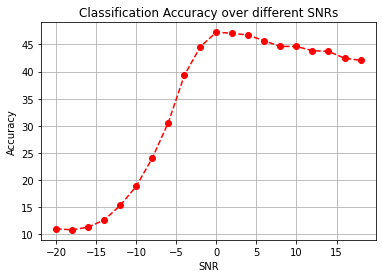

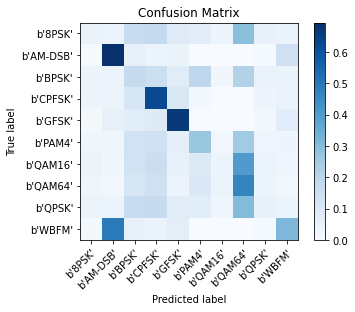

In [ ]:
print(print_results(y_pred_test,  Y_test, snr_test))
plot_results(y_pred_test,  Y_test, snr_test)
plot_confusion_matrix(Y_test, y_pred_test, mods)

###CNN Model

In [ ]:
del model
from tensorflow.keras import layers
def cnn_model():
  #model = keras.Sequential()
  input_img = layers.Input(shape=(4, 128, 1), name="image")
  x = layers.Conv2D(64,(1,3), activation="relu", name="Conv1")(input_img)
  x = layers.Conv2D(16,(2,3),  activation="relu", name="Conv2")(x)
  x = layers.Flatten(name = 'flattened_img')(x)
  x = layers.Dense(128, activation="relu", name="dense1")(x)
  x = layers.Dense(10, activation="softmax", name="dense2")(x)
  model = keras.models.Model(inputs=[input_img], outputs=x, name="cnn_model")
  return model

In [ ]:
model_cnn = cnn_model()
model_cnn.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 4, 128, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 4, 126, 64)        256       
_________________________________________________________________
Conv2 (Conv2D)               (None, 3, 124, 16)        6160      
_________________________________________________________________
flattened_img (Flatten)      (None, 5952)              0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               761984    
_________________________________________________________________
dense2 (Dense)               (None, 10)                1290      
Total params: 769,690
Trainable params: 769,690
Non-trainable params: 0
___________________________________________________

In [ ]:
model_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])
epochs = 200
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
history = model_cnn.fit(
    X_train,
    Y_train,
    batch_size = 400,
    validation_split = 0.05,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/200
1995/1995 [==============================] - 25s 10ms/step - loss: 1.7803 - accuracy: 0.2952 - val_loss: 1.4485 - val_accuracy: 0.4042
Epoch 2/200
1995/1995 [==============================] - 19s 9ms/step - loss: 1.4250 - accuracy: 0.4104 - val_loss: 1.3758 - val_accuracy: 0.4309
Epoch 3/200
1995/1995 [==============================] - 19s 9ms/step - loss: 1.3636 - accuracy: 0.4338 - val_loss: 1.3498 - val_accuracy: 0.4357
Epoch 4/200
1995/1995 [==============================] - 18s 9ms/step - loss: 1.3288 - accuracy: 0.4481 - val_loss: 1.3218 - val_accuracy: 0.4496
Epoch 5/200
1995/1995 [==============================] - 19s 9ms/step - loss: 1.3013 - accuracy: 0.4576 - val_loss: 1.3182 - val_accuracy: 0.4448
Epoch 6/200
1995/1995 [==============================] - 19s 9ms/step - loss: 1.2812 - accuracy: 0.4669 - val_loss: 1.2968 - val_accuracy: 0.4595
Epoch 7/200
1995/1995 [==============================] - 19s 9ms/step - loss: 1.2666 - accuracy: 0.4719 - val_loss: 1.2905 

####Evaluation

In [ ]:
results = model_cnn.evaluate(X_test, Y_test, batch_size=400)
y_pred_test = model_cnn.predict(X_test)
print("test loss, test acc:", results)

900/900 [==============================] - 4s 4ms/step - loss: 1.2999 - accuracy: 0.4580
test loss, test acc: [1.299932837486267, 0.45797500014305115]


           -20    -18    -16    -14    -12  ...    10     12     14     16     18
accuracy  10.3  11.25  11.95  12.87  15.63  ...  70.7  69.97  70.22  69.37  69.18

[1 rows x 20 columns]


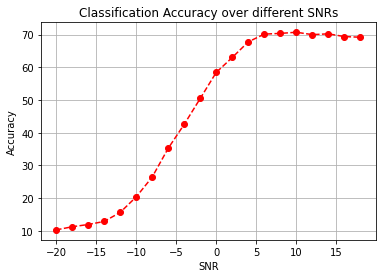

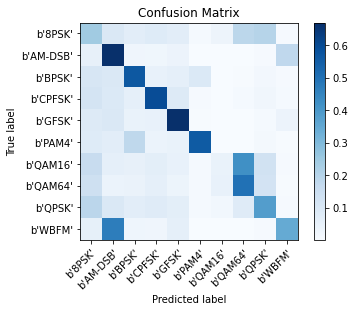

In [ ]:
print(print_results(y_pred_test,  Y_test, snr_test))
plot_results(y_pred_test,  Y_test, snr_test)
plot_confusion_matrix(Y_test, y_pred_test, mods)

# **combinations** **of Raw, derivative and integral**

##Feature Spaces

In [ ]:
del Xd
print(X.shape)
raw = normalize(X[:,0]), normalize(X[:,1])
derivative = normalize(np.gradient(X[:,0], axis = 1)), normalize(np.gradient(X[:,1], axis = 1))
integral = normalize(np.cumsum(X[:,0], axis = 1)), normalize(np.cumsum(X[:,1], axis = 1))
print('Finish')
com_feature = raw
com_feature += derivative
com_feature += integral
del X
del raw
del derivative
del integral
com_feature = np.stack(com_feature, axis = 1)
print(com_feature)
print(com_feature.shape)
lbl = np.array(lbl)

(1200000, 2, 128)
Finish
[[[ 0.12533608  0.0828359  -0.049265   ... -0.0325529  -0.01167205
    0.05498357]
  [-0.00755202  0.11155538  0.0904377  ... -0.08977888 -0.10727949
   -0.10767834]
  [-0.06029993 -0.12386337 -0.01638079 ... -0.0186449   0.06209905
    0.09457203]
  [ 0.16911437  0.06956524 -0.03776356 ... -0.23020586 -0.01270726
   -0.0005663 ]
  [ 0.01147853  0.01906481  0.01455302 ...  0.15236448  0.15129553
    0.15633103]
  [-0.00155472  0.02141102  0.04002929 ... -0.02201433 -0.0440998
   -0.06626738]]

 [[-0.06435594 -0.1615047  -0.10427034 ... -0.13816652 -0.04033643
   -0.07967182]
  [ 0.1242578  -0.13422264  0.01408419 ...  0.0225845  -0.01648061
    0.0780423 ]
  [-0.13455155 -0.02764083  0.00650999 ... -0.0411226   0.04050773
   -0.05447972]
  [-0.34514645 -0.07355688  0.1361285  ... -0.02114303  0.03702613
    0.12621552]
  [-0.00615713 -0.02160878 -0.03158464 ... -0.14844999 -0.1523091
   -0.15993154]
  [ 0.01931132 -0.00154867  0.0006402  ...  0.13048658  0.1279

**Helped_Link:** [Feature_Spaces](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html?fbclid=IwAR0VVCxswWf71tGfxfNENX7sX_DUS3hIIHrqBfuq2loHN22st8THrzfeHVM)

##Spliting DataSet

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(com_feature, lbl, test_size=0.3)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(840000, 6, 128) (840000, 2) (360000, 6, 128) (360000, 2)


In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train , y_train, test_size=0.05)
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(798000, 6, 128) (798000, 2) (42000, 6, 128) (42000, 2)


In [ ]:
nsamples, nx, ny = x_train.shape
x_train2 = x_train.reshape((nsamples, nx*ny))
nsamples, nx, ny = x_test.shape
x_test2 = x_test.reshape((nsamples, nx*ny))
nsamples, nx, ny = x_valid.shape
x_valid2 = x_valid.reshape((nsamples, nx*ny))
del x_train
del x_valid
del x_test
del com_feature
del lbl

In [ ]:
import random
n_examples = com_feature.shape[0]
n_train = n_examples * 0.7
#a = range(0,n_examples)
train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = com_feature[train_idx]
X_test =  com_feature[test_idx]
Y_train = LB().fit_transform(lbl[train_idx][:,0])
Y_test = LB().fit_transform(lbl[test_idx][:,0])
snr_train = lbl[train_idx][:,1].astype(int)
snr_test = lbl[test_idx][:,1].astype(int)
del lbl
del com_feature

In [ ]:
print(X_train.shape,X_test.shape, Y_train.shape, Y_test.shape)

(840000, 6, 128) (360000, 6, 128) (840000, 10) (360000, 10)


##Classifiers



###Logistic Regression

In [ ]:
lr = LogisticRegression()
lr = lr.fit(x_train2, y_train[:,0])
y_pred_valid = lr.predict(x_valid2)
y_pred_test = lr.predict(x_test2)
del lr

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


####Evaluation

In [ ]:
print("Prediction validation:", y_pred_valid)
print("true validation", y_valid[:,0])
acc = accuracy_score(y_valid[:,0], y_pred_valid)
print("Accuracy validation", acc)

Prediction validation: [b'AM-DSB' b'QAM64' b'AM-DSB' ... b'PAM4' b'QAM16' b'QAM64']
true validation [b'PAM4' b'QAM64' b'WBFM' ... b'PAM4' b'BPSK' b'QPSK']
Accuracy validation 0.16735714285714287


            -20    -18    -16    -14    -12  ...    10     12     14     16    18
accuracy  10.19  10.15  11.31  10.15  11.79  ...  19.5  20.88  21.26  19.44  19.5

[1 rows x 20 columns]


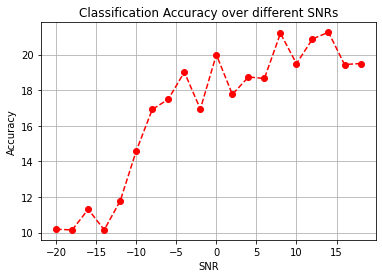

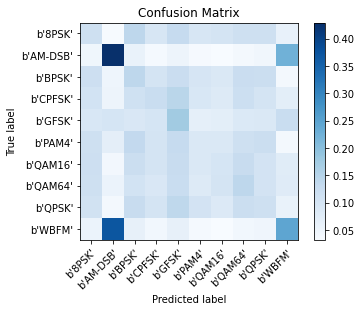

In [ ]:
print(print_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_valid[:,0]), LB().fit_transform(y_pred_valid), mods)

In [ ]:
print("Prediction test:", y_pred_test)
print("true test", y_test[:,0])
acc = accuracy_score(y_test[:,0], y_pred_test)
print("Accuracy test", acc)

Prediction test: [b'QPSK' b'QAM16' b'GFSK' ... b'8PSK' b'PAM4' b'8PSK']
true test [b'CPFSK' b'PAM4' b'GFSK' ... b'QAM16' b'CPFSK' b'QAM16']
Accuracy test 0.16513055555555556


            -20    -18   -16    -14    -12  ...    10     12     14     16     18
accuracy  10.12  10.16  10.2  10.73  11.66  ...  19.6  19.11  20.05  19.51  19.17

[1 rows x 20 columns]


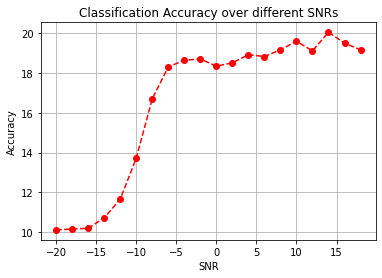

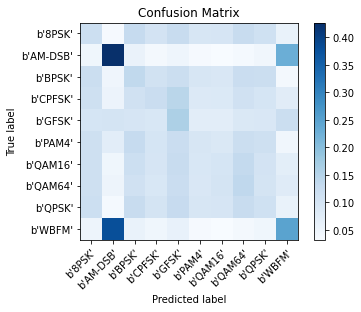

In [ ]:
print(print_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_test[:,0]), LB().fit_transform(y_pred_test), mods)

###Decision Tree



In [ ]:
dr = tree.DecisionTreeClassifier()
dr = dr.fit(x_train2, y_train[:,0])
y_pred_valid = dr.predict(x_valid2)
y_pred_test = dr.predict(x_test2)
del dr

####Evaluation

In [ ]:
print("Prediction validation:", y_pred_valid)
print("true validation", y_valid[:,0])
acc = accuracy_score(y_valid[:,0], y_pred_valid)
print("Accuracy validation", acc)

Prediction validation: [b'PAM4' b'QAM64' b'AM-DSB' ... b'QAM64' b'QAM16' b'GFSK']
true validation [b'PAM4' b'QAM64' b'WBFM' ... b'PAM4' b'BPSK' b'QPSK']
Accuracy validation 0.2768095238095238


            -20    -18    -16   -14    -12  ...     10     12     14     16     18
accuracy  10.47  10.63  10.99  9.87  11.32  ...  44.91  45.96  45.08  47.84  47.96

[1 rows x 20 columns]


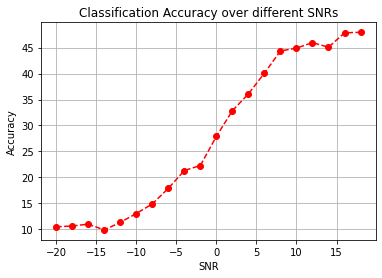

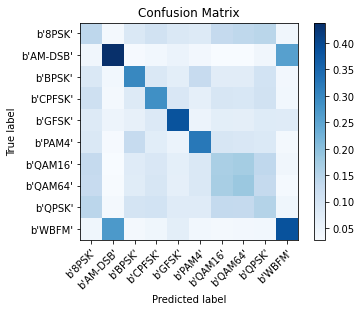

In [ ]:
print(print_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_valid[:,0]), LB().fit_transform(y_pred_valid), mods)

In [ ]:
print("Prediction test:", y_pred_test)
print("true test", y_test[:,0])
acc = accuracy_score(y_test[:,0], y_pred_test)
print("Accuracy test", acc)

Prediction test: [b'8PSK' b'BPSK' b'GFSK' ... b'GFSK' b'GFSK' b'PAM4']
true test [b'CPFSK' b'PAM4' b'GFSK' ... b'QAM16' b'CPFSK' b'QAM16']
Accuracy test 0.2778888888888889


            -20    -18    -16    -14    -12  ...     10     12     14     16     18
accuracy  10.44  10.55  10.21  10.74  11.45  ...  45.54  46.38  47.75  47.72  47.91

[1 rows x 20 columns]


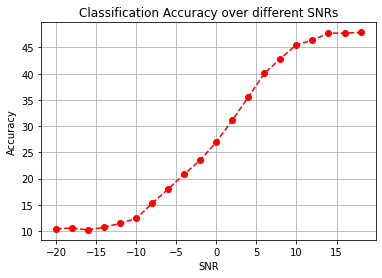

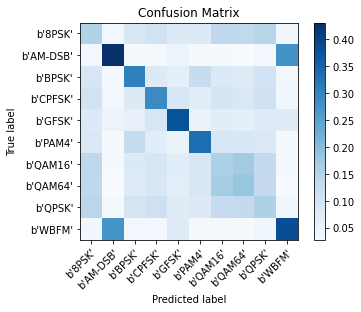

In [ ]:
print(print_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_test[:,0]), LB().fit_transform(y_pred_test), mods)

###Random Forest 



In [ ]:
rfc=RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
rfc.fit(x_train2,y_train[:,0])
y_pred_valid =rfc.predict(x_valid2)
y_pred_test=rfc.predict(x_test2)
del rfc

####Evaluation

In [ ]:
print("Prediction validation:", y_pred_valid)
print("true validation", y_valid[:,0])
acc = accuracy_score(y_valid[:,0], y_pred_valid)
print("Accuracy validation", acc)

Prediction validation: [b'PAM4' b'QAM64' b'AM-DSB' ... b'QPSK' b'BPSK' b'PAM4']
true validation [b'PAM4' b'QAM64' b'WBFM' ... b'PAM4' b'BPSK' b'QPSK']
Accuracy validation 0.33304761904761904


           -20   -18    -16    -14    -12  ...    10     12     14     16     18
accuracy  9.38  11.1  12.23  12.03  14.95  ...  48.3  48.21  49.46  48.47  49.07

[1 rows x 20 columns]


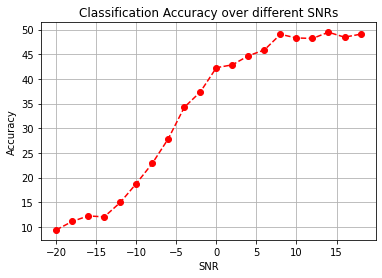

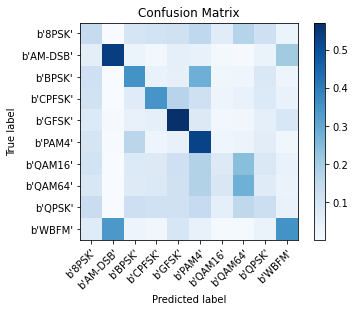

In [ ]:
print(print_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_valid),  LB().fit_transform(y_valid[:,0]), y_valid[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_valid[:,0]), LB().fit_transform(y_pred_valid), mods)

In [ ]:
print("Prediction test:", y_pred_test)
print("true test", y_test[:,0])
acc = accuracy_score(y_test[:,0], y_pred_test)
print("Accuracy test", acc)

Prediction test: [b'QAM64' b'PAM4' b'GFSK' ... b'PAM4' b'CPFSK' b'PAM4']
true test [b'CPFSK' b'PAM4' b'GFSK' ... b'QAM16' b'CPFSK' b'QAM16']
Accuracy test 0.33106944444444447


            -20   -18    -16    -14   -12  ...     10     12     14     16     18
accuracy  10.32  10.6  10.86  12.16  14.3  ...  47.82  47.94  48.54  48.49  47.71

[1 rows x 20 columns]


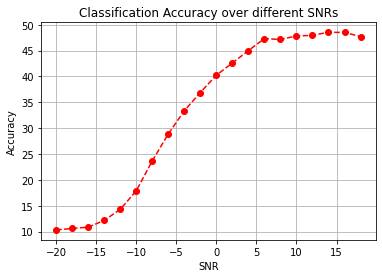

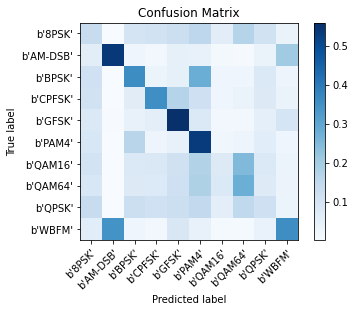

In [ ]:
print(print_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int)))
plot_results(LB().fit_transform(y_pred_test),  LB().fit_transform(y_test[:,0]), y_test[:,1].astype(int))
plot_confusion_matrix(LB().fit_transform(y_test[:,0]), LB().fit_transform(y_pred_test), mods)

###Fully Connected Dense Layer



In [ ]:
model = keras.Sequential()
model.add(layers.Dense(256, activation= "relu", name= "dense1",kernel_regularizer='l2', input_shape= (6, 128)))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation ='softmax')) #10 classes
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 6, 256)            33024     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                15370     
Total params: 48,394
Trainable params: 48,394
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 200
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
history = model.fit(
    X_train,
    Y_train,
    batch_size = 400,
    validation_split = 0.05,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/200
1995/1995 [==============================] - 9s 3ms/step - loss: 2.1827 - accuracy: 0.2361 - val_loss: 1.8409 - val_accuracy: 0.3132
Epoch 2/200
1995/1995 [==============================] - 10s 5ms/step - loss: 1.8260 - accuracy: 0.3168 - val_loss: 1.7935 - val_accuracy: 0.3257
Epoch 3/200
1995/1995 [==============================] - 7s 3ms/step - loss: 1.7878 - accuracy: 0.3290 - val_loss: 1.7780 - val_accuracy: 0.3291
Epoch 4/200
1995/1995 [==============================] - 10s 5ms/step - loss: 1.7694 - accuracy: 0.3322 - val_loss: 1.7609 - val_accuracy: 0.3319
Epoch 5/200
1995/1995 [==============================] - 7s 3ms/step - loss: 1.7561 - accuracy: 0.3356 - val_loss: 1.7505 - val_accuracy: 0.3344
Epoch 6/200
1995/1995 [==============================] - 7s 3ms/step - loss: 1.7475 - accuracy: 0.3372 - val_loss: 1.7467 - val_accuracy: 0.3361
Epoch 7/200
1995/1995 [==============================] - 7s 3ms/step - loss: 1.7439 - accuracy: 0.3379 - val_loss: 1.7406 - val_

####Evaluation

In [ ]:
results = model.evaluate(X_test, Y_test, batch_size=400)
y_pred_test = model.predict(X_test)
print("test loss, test acc:", results)

900/900 [==============================] - 2s 3ms/step - loss: 1.6534 - accuracy: 0.3649
test loss, test acc: [1.6534249782562256, 0.36494165658950806]


            -20    -18    -16    -14    -12  ...     10     12     14    16     18
accuracy  10.22  11.04  11.25  12.94  15.93  ...  48.67  48.88  49.05  49.1  48.46

[1 rows x 20 columns]


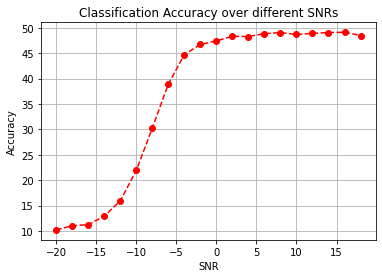

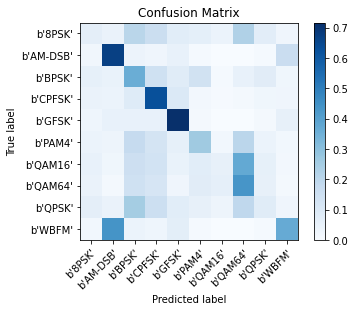

In [ ]:
print(print_results(y_pred_test,  Y_test, snr_test))
plot_results(y_pred_test,  Y_test, snr_test)
plot_confusion_matrix(Y_test, y_pred_test, mods)

###CNN Model

In [ ]:
del model
from tensorflow.keras import layers
def cnn_model():
  #model = keras.Sequential()
  input_img = layers.Input(shape=(6, 128, 1), name="image")
  x = layers.Conv2D(64,(1,3), activation="relu", name="Conv1")(input_img)
  x = layers.Conv2D(16,(2,3),  activation="relu", name="Conv2")(x)
  x = layers.Flatten(name = 'flattened_img')(x)
  x = layers.Dense(128, activation="relu", name="dense1")(x)
  x = layers.Dense(10, activation="softmax", name="dense2")(x)
  model = keras.models.Model(inputs=[input_img], outputs=x, name="cnn_model")
  return model

In [ ]:
model_cnn = cnn_model()
model_cnn.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 6, 128, 1)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 6, 126, 64)        256       
_________________________________________________________________
Conv2 (Conv2D)               (None, 5, 124, 16)        6160      
_________________________________________________________________
flattened_img (Flatten)      (None, 9920)              0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               1269888   
_________________________________________________________________
dense2 (Dense)               (None, 10)                1290      
Total params: 1,277,594
Trainable params: 1,277,594
Non-trainable params: 0
_______________________________________________

In [ ]:
model_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])
epochs = 200
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
history = model_cnn.fit(
    X_train,
    Y_train,
    batch_size = 400,
    validation_split = 0.05,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/200
1995/1995 [==============================] - 27s 11ms/step - loss: 1.5080 - accuracy: 0.4017 - val_loss: 1.1477 - val_accuracy: 0.5190
Epoch 2/200
1995/1995 [==============================] - 19s 10ms/step - loss: 1.1172 - accuracy: 0.5349 - val_loss: 1.1010 - val_accuracy: 0.5398
Epoch 3/200
1995/1995 [==============================] - 19s 10ms/step - loss: 1.0723 - accuracy: 0.5525 - val_loss: 1.0803 - val_accuracy: 0.5463
Epoch 4/200
1995/1995 [==============================] - 19s 10ms/step - loss: 1.0495 - accuracy: 0.5610 - val_loss: 1.0661 - val_accuracy: 0.5482
Epoch 5/200
1995/1995 [==============================] - 19s 10ms/step - loss: 1.0282 - accuracy: 0.5706 - val_loss: 1.0658 - val_accuracy: 0.5487
Epoch 6/200
1995/1995 [==============================] - 19s 10ms/step - loss: 1.0118 - accuracy: 0.5774 - val_loss: 1.0724 - val_accuracy: 0.5505
Epoch 7/200
1995/1995 [==============================] - 19s 10ms/step - loss: 0.9950 - accuracy: 0.5860 - val_loss: 1

####Evaluation

In [ ]:
results = model_cnn.evaluate(X_test, Y_test, batch_size=400)
y_pred_test = model_cnn.predict(X_test)
print("test loss, test acc:", results)

900/900 [==============================] - 4s 5ms/step - loss: 1.0640 - accuracy: 0.5484
test loss, test acc: [1.0640406608581543, 0.5484499931335449]


           -20    -18    -16    -14   -12  ...     10     12     14     16     18
accuracy  9.94  10.59  11.36  13.58  18.1  ...  81.65  81.64  81.62  81.13  81.16

[1 rows x 20 columns]


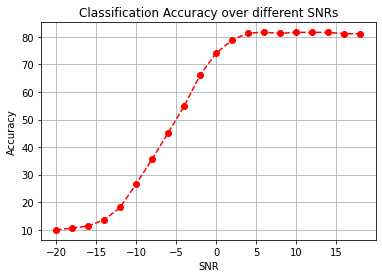

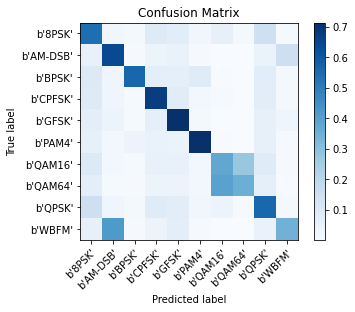

In [ ]:
print(print_results(y_pred_test,  Y_test, snr_test))
plot_results(y_pred_test,  Y_test, snr_test)
plot_confusion_matrix(Y_test, y_pred_test, mods)